# Wykrywanie fałszywych zgłoszeń ubezpieczeniowych

**Autorzy**: *Szymon Półtorak, Adrian Nowosielski, Cezary Skorupski*
**Prowadzący**: *mgr. inż. Mateusz Bartosiewicz*

## Cel Projektu

Celem projektu jest przeanalizowanie zbioru danych dotyczącego wykrywania zgłoszeń ubezpieczeniowych. Również ważnym aspektem projektu jest znalezienie odpowiedniego klasyfikatora do wykrywania tych zgłoszeń.

## Zaciąganie zależności

Dodanie wszystkich istotnych zależności.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier

## Wstępna analiza zbioru danych

**Początkowy opis badanego zbioru danych:**
> Badany zbiór danych jest to najwyraźniej prawdziwy baza danych pochodząca od amerakańskiego ubezpieczyciela, która została udostępniona przez firmę Oracle w celu prowadzenia eksploracji do wykrywania fałszywych zgłoszeń ubezpieczeniowych. Oszustwa związane z ubezpieczeniami samochodowymi obejmują składanie fałszywych złożeń lub przesadzonych zgłoszeń dotyczących szkód w celu otrzymania większego odszkodowania. Niektóre typowe przykłady fałszywych zgłoszeń na przykład obejmują zainscenizowane wypadki, w których oszuści celowo organizują wypadki wraz na przykład ze znajomym, który występuje w roli poszkodowanego. Wykorzysytwanie "widmowych" pasażerów to przykład oszustwa, w którym osoba twierdzi, że odniosła poważne obrażenia oraz składanie fałszywych roszczeń z tytułu odniesionych obrażeń, podczas gdy naprawdę są rażąco przesadzone.

*Rozpocznijmy pracę nad zbiorem*
> Celem projektu jest znalezienie zależności pomiędzy występowaniem oszustw w ubezpieczeniach samochodowych na podstawie odpowiednich informacji ze zgłoszenia. Projekt zostanie wykonany na podstawie bibliotekę pandas. Do klasyfikacji oszustw wykorzystamy bibliotekę ski-kit learn oraz wykorzystamy typowe klasyfikatory, które poznaliśmy na zajęciach wykładowych. Wczytajmy w takim razie ramkę danych oraz wyświetlmy kilka podstawowych obiektów ramki.

In [2]:
FRAUD: int = 1
NOT_FRAUD: int = 0

data_frame: pd.DataFrame = pd.read_csv("fraud_oracle.csv")
data_frame.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


W celu wykonania poprawnej analizy danych potrzebne jest dobre zapoznanie się z badanym zbiorem danych. Spróbujmy dokonać opisu atrybutów obiektów występujących w macierzy danych:

**Opis występujących w zbiorze atrybutów:**
> 1. **Month - miesiąc, w którym wystąpił zgłoszony przez poszkodwanego wypadek.**
> 2. **WeekOnMonth - dzień miesiąca, w którym wystąpił zgłoszony przez poszkodowanego wypadek.**
> 3. **DayOfWeek - dzień tygodnia, w którym wystąpił zgłoszony przez poszkodowanego wypadek.**
> 4. **Make - marka pojazdu, który prowadził poszkodowany.**
> 5. **AccidentArea - informacja w jakich obszarach miał miejsce wypadek( miejskich lub wiejskich ).**
> 6.  **DayOfWeekClaimed - dzień tygodnia, w którym została złożona reklamacja.**
> 7.  **Sex - płeć osoby zgłaszającej szkodę.**
> 8.  **MartialStatus - stan cywilny osoby zgłaszającej skargę.**
> 9.  **Age - wiek osoby składającej skargę.**
> 10. **Fault - informacja o tym, kto był winowajcą reklamowanego zdarzenia( czy winowajcą zdarzenia był właściciel ubezpiczenia, czy inna osoba )**
> 11. **PolicyType - Połączenie typu samochodu i rodzaju polisy: Odpowiedzialność cywilna (wobec osób trzecich), Kolizja (obejmuje uszkodzenie pojazdu właściciela), Wszystkie niebezpieczeństwa (od wszystkich ryzyk).**
> 12. **VehicalCategory - klasyfikacja typu samochodu( kategoryzacja typu samochodu ).**
> 13. **VehicalPrice - cena pojazdu, który został uszkodzony lub brał udział w reklamowanym wydarzeniu.**
> 14. **FraudFound_P - kolumna do przewidzenia, czy incydent był oszustwem, czy nie( możliwy atrybut do klasyfikacji ).**
> 15. **PolicyNumber - Unikalny numer wypadku, zgodny z liczbą wierszy w zbiorze danych( jest to zbędna danych, podobna do indeksu).**
> 16. **RepNumber - numeracja od jednego do szesnastu.**
> 17. **Deductible - jest to koszt ubezpieczenia.**
> 18. **DriverRating - jest to ocena kierowcy podana jako liczba całkowita.**
> 19. **Days_Policy_Accident - zakres nabycia ubezpieczenia i zdarzenie wypadku( dni między nabyciem ubezpieczenia a wypadkiem ).**
> 20. **Days_Policy_Claim - przedział pomiędzy wykupieniem ubezpieczenia a zgłoszeniem wypadku( dni między nabyciem ubezpieczenia, a zgłoszeniem szkody ).**
> 21. **PastNumberOfClaims - liczba poprzednich reklamacji złożonych przez właściciela pojazdu.**
> 22. **AgeOfVehicle - wiek pojazdu poddanego szkodzie.**
> 23. **AgeOfPoliceHolder - wiek posiadacza ubezpieczenia.**
> 24. **PoliceReportFiled - informacja o tym czy wypadek został zgłoszony na policję.**
> 25. **WitnessPresent - informacja o tym czy na miejscu wypadku był jakiś świadek, który by mógł potwierdzić wersję zdarzeń.**
> 26. **AgentType - informacja o tym czy osoba zgłaszająca jest pracownikiem firmy ubezpieczeniowej.**
> 27. **NumberOfSuppliments - są to uszkodzenia pojazdu niezarejestrowane w momencie reklamacji, dodatkowe uszkodzenia, które nie są widoczne z zewnątrz, zwykle uszkodzenia elementów wewnętrznych.**
> 28. **AddresChange_Claim - informacja o tym, czy właściciel ubezpieczenia przeniósł się po zgłoszeniu wypadku i jak długo po nim.**
> 29. **NumberOfCars - informacja o tym ile pojazdów brało udział w wypadku.**
> 30. **Year - rok, w którym miał miejsce wypadek.**
> 31. **BasePolicy - rodzaj ubezpieczenia.**

**Wstępne informacje:**
* W zbiorze danych występuje coś rodzaju indeksu (jest to numer polisy, który możemy usunąć w celu dalszego badania zbioru, ponieważ jest on dla nas zbędny).
* Dodatkowo w atrybucie FraudFound_P mamy informację o tym, czy dany wypadek był oszustwem (można spróbować użyć atrybutu klasyfikacji oszustw).

*Dalsze kroki ze zbiorem danych:*
> Po wstępnym zapoznaniu się ze zbiorem wykonujemy jego analizę eksploracyjną, czyli sprawdzamy liczbę obiektów w zbiorze danych, sprawdzamy liczbę brakujących danych w zbiorze, liczymy podstawowe miary tendencji centralnej, miary rozrzutu dla atrybutów oraz dowiadujemy się o typach danych atrybutów obiektów. Na początku spróbujmy zbadać funkcją describe podstawowe miary tendencji centralnej oraz rozrzutu poszczególnych atrybutów.

In [3]:
data_frame.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


*Wnioski z analizy:*
* Widzimy, że wartościami numerycznymi jest 9 kolumn spośród wszystkich w naszym zbiorze danych. Na ich podstawie mogliśmy obliczyć miary tendencji centralnej oraz rozrzutu.
* Badanie atrybutów WeekOfMonth, WeekOfMonthClaimed, FraudFound_P, PolicyNumber oraz Year jest bez sensu w tym przypadku, dlatego możemy pominąć je w tej analizie.
* Widzimy, że mediana wieku zgłaszających osób wynosi około 40 lat. Warto też zauważyć, że jest całkiem duże odchylenie standardowe, bo aż 13 lat, natomiast maksymalny wiek osoby zgłaszającej to 80.
* Widzimy, że średnia oceny kierowców według atrybutu DriverRating wynosi 2.48. Według atrybutu, który mówi, że najlepsza ocena to 4 możemy powiedzieć, że ocena kierowców podczas wypadku jest powyżej średniej.

*Teraz spróbujmy wyświetlić informacje o podstaowych typach danych atrybutów obiektu w celu lepszego zapoznania się z badanym zbiorem:*

In [4]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

*Wnioski z analizy:*
* Tak jak wcześniej to zauważyliśmy, większość atrybutów nie jest typu ilościowego w takim razie nie możemy obliczyć dla nich na przykład średniej.
* Większość atrybutów obiektu jest typu object.

*Funkcja describe_frame odpowiada za wyświetlenie podstawowych danych o zbiorze danych. Podstawowe dane to na przykład liczba atrybutów, liczba obiektów, liczba brakujących obiektów. Funkcja służy do wyświetlenia informacji w celu lepszego zapoznania się ze zbiorem:*

*Druga funkcja display_uniques odpowiada za wyświetlenie unikalnych wartości poszczególnych atrybutów. Jest to zrobione po to, żeby zobaczyć ile unikalnych wartości występuje w poszczególnych atrybutach oraz określenie czy nie ma innego rodzaju braków danych w zbiorze:*

In [5]:
def describe_frame(frame: pd.DataFrame, class_name: str = "FraudFound_P") -> None:
    """
    Function used to display number of objects, attributes, missing objects
    :param class_name: name of class column name
    :param frame: pandas DataFrame
    :return: None
    """
    class_column: pd.DataFrame = frame.loc[:, class_name]

    print(f'Number of Objects : {frame.shape[0]}')
    print(f'Number of attributes : {frame.shape[1]}')
    print(f'Number of missing objects : {frame.isnull().isnull().sum().sum()}\n')

    for name_of_class in list(class_column.unique()):
        name: str = "Fraud" if name_of_class == FRAUD else "NotFraud"

        print(f"Class : {name}\n\tNum Of Objects : {len(frame[frame[class_name] == name_of_class])}")


def display_uniques(frame: pd.DataFrame) -> None:
    """
    Displays unique values for the give frame
    :param frame: pandas DataFrame instance
    """
    for column in frame.columns:
        print(f'Unique values in attribute: {column}\n\t{(frame[column].unique())}\n')

Teraz wykorzystamy naszej funkcji *describe_frame* do opisania naszej ramki danych

In [6]:
describe_frame(data_frame)

Number of Objects : 15420
Number of attributes : 33
Number of missing objects : 0

Class : NotFraud
	Num Of Objects : 14497
Class : Fraud
	Num Of Objects : 923


*Wnioski z analizy:*
* Widzimy, że wszystkich obiektów w macierzy danych jest 15420, więc jest to stosunkowo duży zbiór przypadków.
* Liczba atrybutów ogólnie wynosi 33. Wiemy, że liczba atrybutów ilościowych wynosi 6 z poprzedniej analizy, więc większość atrybutów nie jest ilościowa.
* W zbiorze nie występują braki danych null.
* Po dokonaniu podziału na przypadki, w których wykryto oszustwo oraz nie, wychodzi na to, że około 6% wszystkich przypadków to oszustwa.

*Teraz spróbujmy uruchomić funkcję display_uniqes na naszej macierzy danych:*


In [7]:
display_uniques(data_frame)

Unique values in attribute: Month
	['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']

Unique values in attribute: WeekOfMonth
	[5 3 2 4 1]

Unique values in attribute: DayOfWeek
	['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']

Unique values in attribute: Make
	['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']

Unique values in attribute: AccidentArea
	['Urban' 'Rural']

Unique values in attribute: DayOfWeekClaimed
	['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']

Unique values in attribute: MonthClaimed
	['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']

Unique values in attribute: WeekOfMonthClaimed
	[1 4 2 3 5]

Unique values in attribute: Sex
	['Female' 'Male']

Unique values in attribute: MaritalStatus
	['Single' 'Married' 'Widow' 'Divorced']

Unique values in

*Wnioski z analizy:*
* Widzimy ciekawe anomalia występujące w niektórych wartościach atrybutów. Na przykład w przypadku DayOfWeekClaimed mamy sytuację występowania 0, jako dzień tygodnia. Chodzi tutaj prawdopodobnie o braku informacji o tym atrybucie. Podobna sytuacja występuje w atrybucie MonthClaimed.
* Zgodnie z przewidywaniami atrybut PolicyNumber jest bezużyteczny, ponieważ jest to po prostu określenie indeksu zgłoszenia.
* Wszystkie przypadki zgłoszeń są w latach 1994 - 1996.
* Atrybut driver-rating zmienia się w zakresie od 1-4.
* W atrybucie FraudFound_P liczba 1 oznacza, że dane zdarzenie było oszustwem, natomiast 0 oznacza, że wydarzenie było prawdziwe.
* W atrybucie Age występuje wartość równa 0. Może to być odpowiednik wartości null.

*Spróbujmy teraz funkcją describe podobnie jak wcześnie opisać obiekty, które nie były oszustwami. Pozwoli n spojrzeć na zależności wartości atrybutów ilościowych:*

In [8]:
print(data_frame[data_frame["FraudFound_P"] == NOT_FRAUD].describe())

        WeekOfMonth  WeekOfMonthClaimed           Age  FraudFound_P  \
count  14497.000000        14497.000000  14497.000000       14497.0   
mean       2.792440            2.695799     39.956957           0.0   
std        1.287957            1.259360     13.462013           0.0   
min        1.000000            1.000000      0.000000           0.0   
25%        2.000000            2.000000     31.000000           0.0   
50%        3.000000            3.000000     38.000000           0.0   
75%        4.000000            4.000000     49.000000           0.0   
max        5.000000            5.000000     80.000000           0.0   

       PolicyNumber     RepNumber    Deductible  DriverRating          Year  
count  14497.000000  14497.000000  14497.000000  14497.000000  14497.000000  
mean    7733.351038      8.492033    407.511899      2.485756   1994.871491  
std     4451.524899      4.604212     43.770260      1.119184      0.803706  
min        1.000000      1.000000    300.000000 

*Wnioski z analizy:*
* Z analizy widzimy, że niestety nic się nie wyróżnia względem całego zbioru danych. Ocena kierowców jest średnio praktycznie taka sama, jak ogólna, z wiekiem jest również podobnie.

*Spróbujmy teraz funkcją describe podobnie jak wcześnie opisać obiekty, które były oszustwami. Pozwoli n spojrzeć na zależności wartości atrybutów ilościowych:*

In [9]:
print(data_frame[data_frame["FraudFound_P"] == FRAUD].describe())

       WeekOfMonth  WeekOfMonthClaimed         Age  FraudFound_P  \
count   923.000000          923.000000  923.000000         923.0   
mean      2.728061            2.665222   38.265439           1.0   
std       1.280906            1.255596   13.871426           0.0   
min       1.000000            1.000000    0.000000           1.0   
25%       2.000000            2.000000   30.000000           1.0   
50%       3.000000            3.000000   36.000000           1.0   
75%       4.000000            4.000000   46.000000           1.0   
max       5.000000            5.000000   80.000000           1.0   

       PolicyNumber   RepNumber  Deductible  DriverRating         Year  
count    923.000000  923.000000  923.000000    923.000000   923.000000  
mean    7351.592633    8.345612  410.725894      2.520043  1994.787649  
std     4438.345948    4.532690   46.619027      1.123781     0.793397  
min       29.000000    1.000000  300.000000      1.000000  1994.000000  
25%     3535.000000   

*Wnioski z analizy:*
* Z analizy widzimy, że niestety nic się nie wyróżnia względem całego zbioru danych. Ocena kierowców jest średnio praktycznie taka sama, jak ogólna, z wiekiem jest również podobnie.

*Usuwanie braków danych w zbiorze:*
> Z poprzedniej analizy jesteśmy w stanie powiedzieć, że w zbiorze występują braki danych. Przykładowo w atrybucie DayOfWeek występuje wartość 0, która jest równoznaczna z brakiem danej. Spróbujmy w takim razie usunąć obiekty, w których mamy braki danych.

In [10]:
data_frame_no_nulls: pd.DataFrame = data_frame[data_frame["Age"] != 0]
data_frame_no_nulls = data_frame_no_nulls[data_frame_no_nulls["DayOfWeekClaimed"] != "0"]
data_frame_no_nulls = data_frame_no_nulls[data_frame_no_nulls["MonthClaimed"] != "0"]
data_frame_no_nulls = data_frame_no_nulls.drop_duplicates()

data_frame_no_nulls

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


Wykorzystując funkcję *describe_frame* porównamy teraz ramkę danych przed usunięciem wartości *null* od tej po usunięciu.

In [11]:
describe_frame(data_frame)

Number of Objects : 15420
Number of attributes : 33
Number of missing objects : 0

Class : NotFraud
	Num Of Objects : 14497
Class : Fraud
	Num Of Objects : 923


In [12]:
describe_frame(data_frame_no_nulls)

Number of Objects : 15100
Number of attributes : 33
Number of missing objects : 0

Class : NotFraud
	Num Of Objects : 14208
Class : Fraud
	Num Of Objects : 892


*Wnioski z analizy:*
> Widzimy, że po usunięciu naszych brakujących danych zbiór uszczuplił nam się zaledwie o 320 obiektów, więc nie jest to dużo w porównaniu do całego zbioru obiektów. Jeśli chodzi o zbiór obiektów, które były oszustwami, to został on pomniejszony o około 30 obiektów.

## Analiza poszczególnych atrybutów

*Analiza zbioru po usunięciu obiektów:*
> Powinniśmy również wykonać analizę wartości atrybutów obiektów po usunięciu w celu określenia czy jakaś wartość atrybutu nie zniknęła po usunięciu obiektów.

In [13]:
display_uniques(data_frame_no_nulls)

Unique values in attribute: Month
	['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep' 'Nov']

Unique values in attribute: WeekOfMonth
	[5 3 2 4 1]

Unique values in attribute: DayOfWeek
	['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']

Unique values in attribute: Make
	['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']

Unique values in attribute: AccidentArea
	['Urban' 'Rural']

Unique values in attribute: DayOfWeekClaimed
	['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday']

Unique values in attribute: MonthClaimed
	['Jan' 'Nov' 'Jul' 'Feb' 'Dec' 'Apr' 'Mar' 'Aug' 'May' 'Jun' 'Sep' 'Oct']

Unique values in attribute: WeekOfMonthClaimed
	[1 4 2 3 5]

Unique values in attribute: Sex
	['Female' 'Male']

Unique values in attribute: MaritalStatus
	['Single' 'Married' 'Widow' 'Divorced']

Unique values in attribute

*Wnioski z analizy:*
> Po przeanalizowaniu wartości atrybutów w zmienionym zbiorze jesteśmy w stanie stwierdzić, że wszystko się zgadza z właściwym zbiorem oraz żadne wartości nie zniknęły z poszczególnych atrybutów.

In [14]:
print(f"PolicyNumber uniques : {len(data_frame_no_nulls['PolicyNumber'].unique())}")
print(f"RepNumber uniques : {len(data_frame_no_nulls['RepNumber'].unique())}")

PolicyNumber uniques : 15100
RepNumber uniques : 16


In [15]:
data_frame_no_nulls = data_frame_no_nulls.drop(columns=["PolicyNumber", "RepNumber"])
data_frame_no_nulls

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


*Usunięcie niepotrzebnych kolumn:*
> Widzimy, że liczba unikalnych wartości atrybutu PolicyNumber wynosi tyle samo ile liczba obiektów. Jest to w takim razie odpowiednik indeksu dla zgłoszenia, czym nie jesteśmy zainteresowani w analize zbioru. Również mamy atrybut RepNumber, który również jest swoistym indeksem, więc również możemy się go pozbyć, ponieważ nie jest nam potrzebny w analizie.

*Wizualizacja przypadków oszustw:*
> Wykonujemy wizualizację obiektów w celu spojrzenia, jak bardzo jest duży przeskok w liczbie oszustw oraz liczbie poprawnych zgłoszeń ubezpieczeniowych.

[Text(0.5, 1.0, 'Frauds Barplot')]

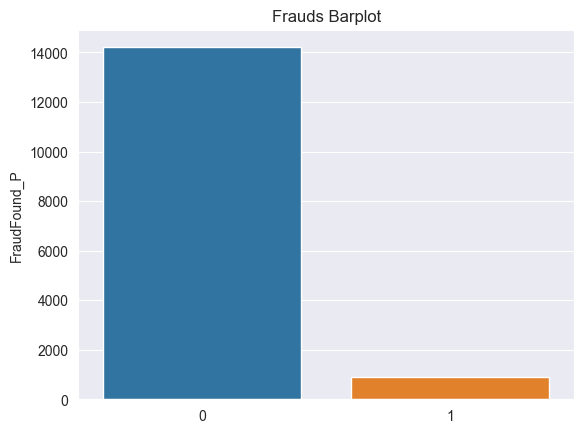

In [16]:
sns.barplot(x=data_frame_no_nulls['FraudFound_P'].unique(), y=data_frame_no_nulls['FraudFound_P'].value_counts()).set(title='Frauds Barplot')

*Wnioski z analizy:*
* Na wykresie kolumnowym widzimy, jak duży jest przeskok pomiędzy liczbą oszustw oraz liczbą poprawnych zgłoszeń.

*Wizualizacja zbioru danych:*
> W celu wizualizacji zbioru danych została stworzona funkcja, która wyświetla wykresy różnicy pomiędzy obiektami, które były poprawnymi zgłoszeniami oraz oszustwami. Są to wykresy kolumnowe. Funkcja przyjmuje odpowiednią ramkę danych, atrybut do porównania, main_class oraz informacje o typie wykresu. Wykres jest tworzony po to, żeby zobaczyć różnicę dla zbioru oszustw oraz prawdziwych na podstawie poszczególnych atrybutów oraz wydzielić atrybuty, które będą przydatne w klasyfikacji (budowanie modelu).

In [17]:
def plot_comparison_bar_plots(frame: pd.DataFrame, compare_category: str, main_class: str = "FraudFound_P",
                              vertical: bool = False) -> None:
    """
    Function used to plot comparison bar plots between main class and the comparison category
    :param vertical: tells function to plot vertically plots or horizontally
    :param main_class: main class of a frame
    :param frame: pandas dataframe instance
    :param compare_category: category of which we want to create bar plots showing frauds in them
    """
    fraud_only: pd.DataFrame = frame[frame[main_class] == FRAUD]
    no_frauds: pd.DataFrame = frame[frame[main_class] == NOT_FRAUD]

    if not vertical:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 2, 1)
        plt.title("No Frauds")
        plot = sns.barplot(x=no_frauds[compare_category].value_counts().index,
                           y=no_frauds[compare_category].value_counts())
        plot.set_xticklabels(plot.get_xticklabels(), rotation=20, ha="left")

        plt.subplot(1, 2, 2)
        plt.title("Frauds only")
        plot = sns.barplot(x=fraud_only[compare_category].value_counts().index,
                           y=fraud_only[compare_category].value_counts())
        plot.set_xticklabels(plot.get_xticklabels(), rotation=20, ha="left")
    else:
        plt.figure(figsize=(20, 8))

        plt.subplot(2, 1, 1)
        plt.title("No Frauds")
        sns.barplot(x=no_frauds[compare_category].value_counts().index, y=no_frauds[compare_category].value_counts())

        plt.subplot(2, 1, 2)
        plt.title("Frauds only")
        sns.barplot(x=fraud_only[compare_category].value_counts().index, y=fraud_only[compare_category].value_counts())

*Metoda plot_attributes_histograms przyjmuje odpowiednią ramkę danych, natomiast na wyjściu zwraca nam wizualizację histogramu poszczególnych atrybutów.*

In [18]:
def plot_attributes_histograms(frame: pd.DataFrame) -> None:
    """
    Function to display dataframe columns histograms
    :param frame: pandas data frame instance
    :return: None
    """
    for attribute in list(frame.columns):
        if attribute == "FraudFound_P":
            continue
        if attribute in ("Age", "Make"):
            plot_comparison_bar_plots(frame, attribute, vertical=True)
        else:
            plot_comparison_bar_plots(frame, attribute)

Przeanalizujemy teraz wszystkie atrybuty w ramce danych, analizując ich histogramy.

C:\Users\Admin\AppData\Local\Temp\ipykernel_25368\1847756763.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 5))


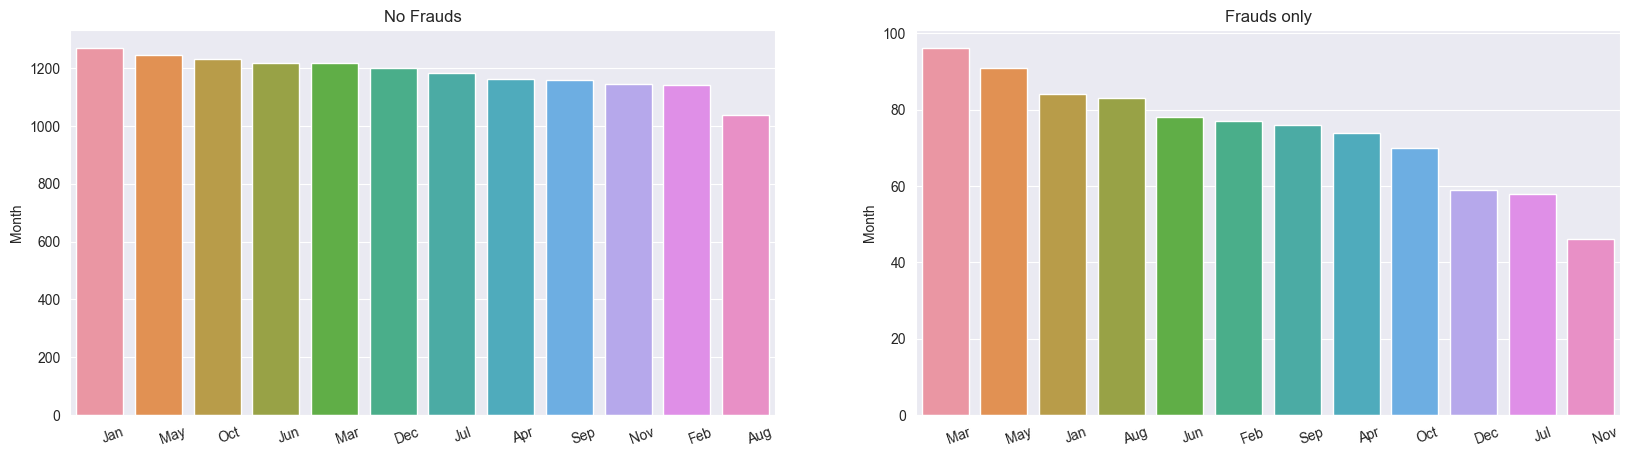

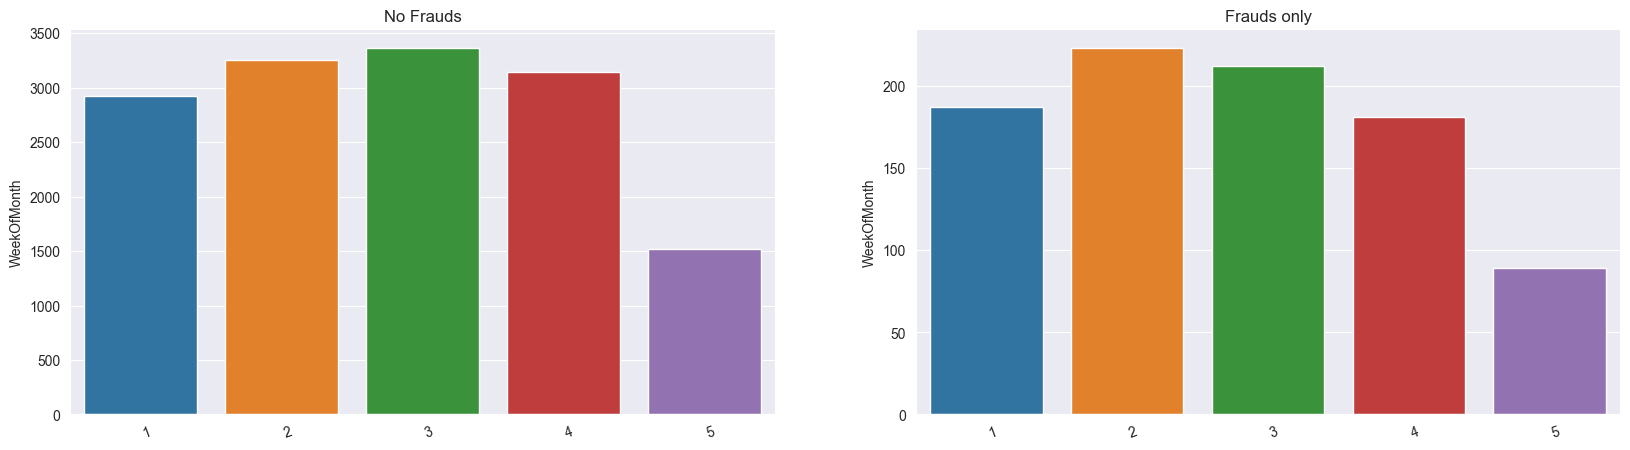

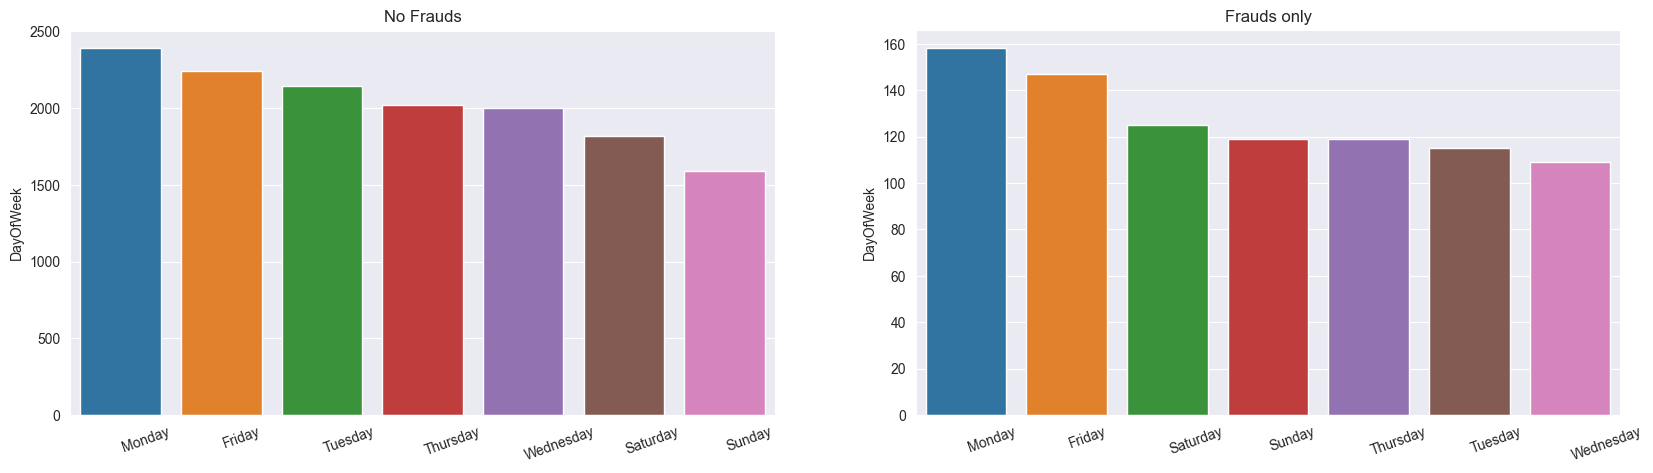

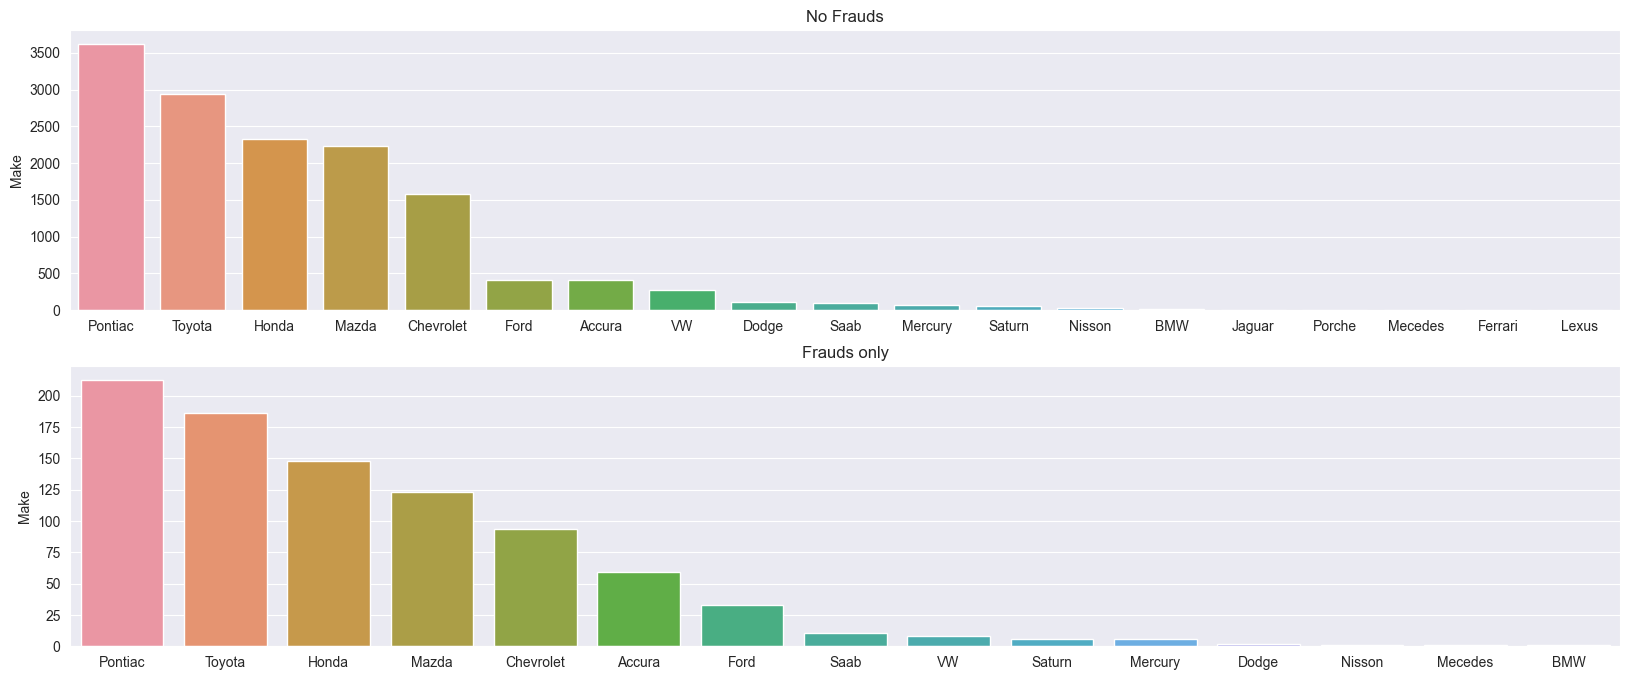

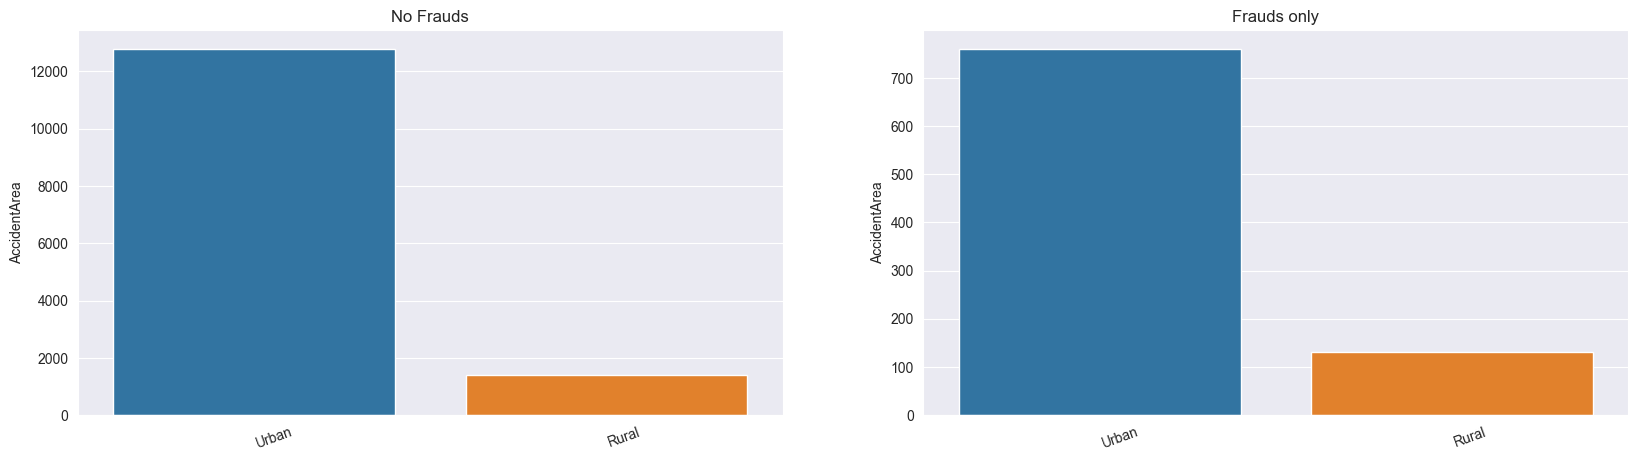

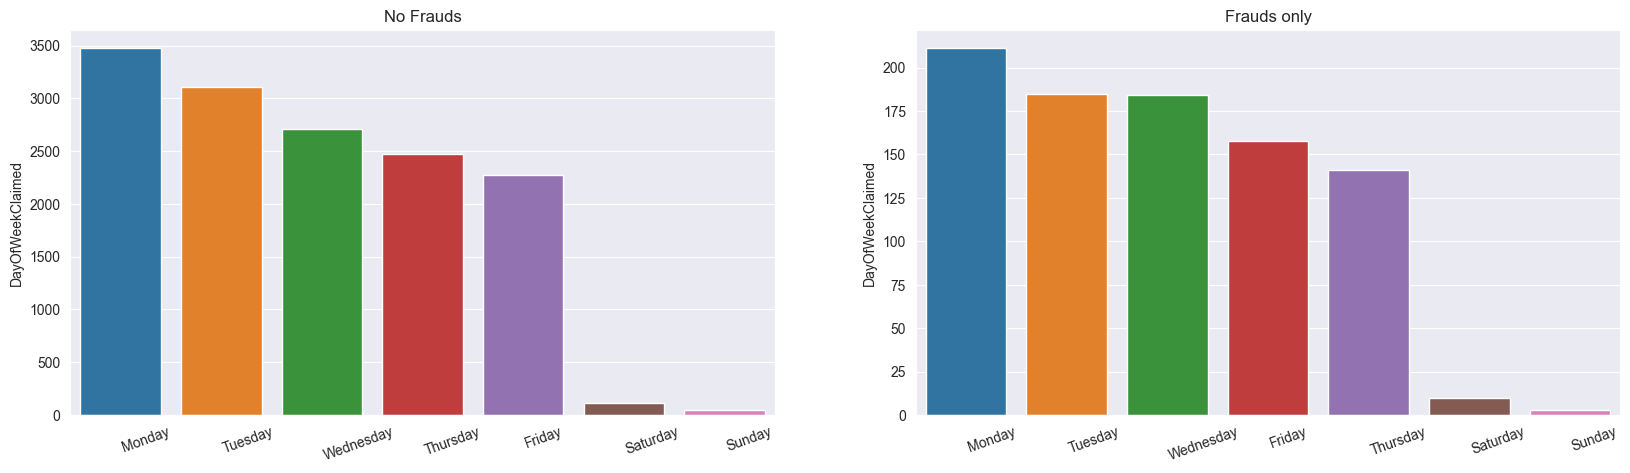

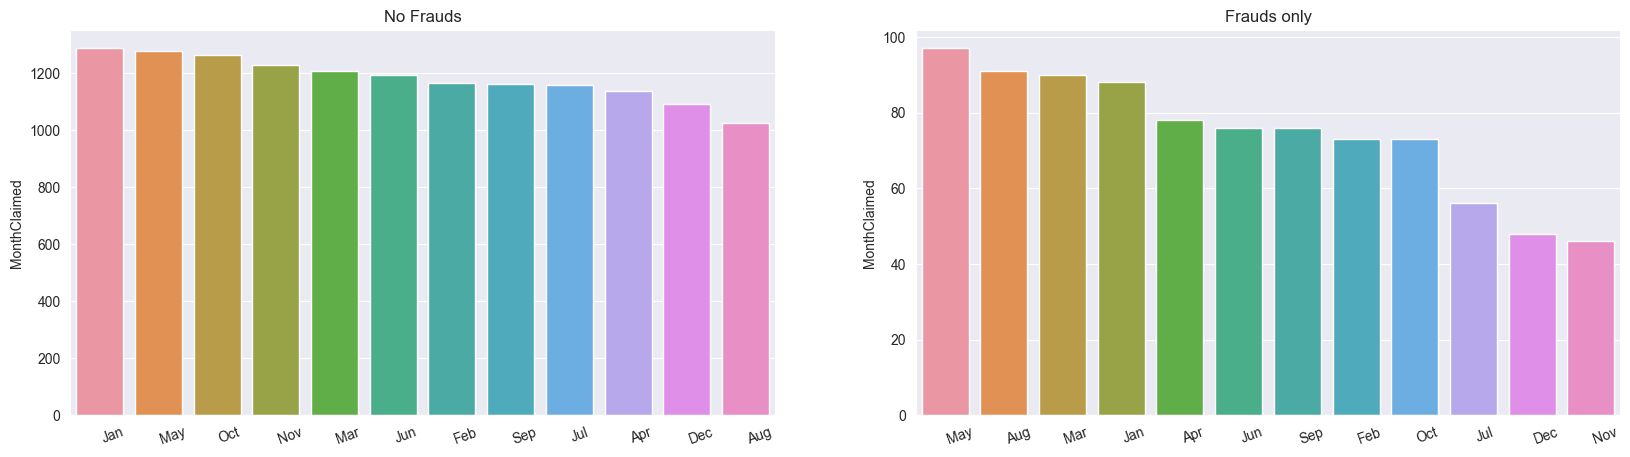

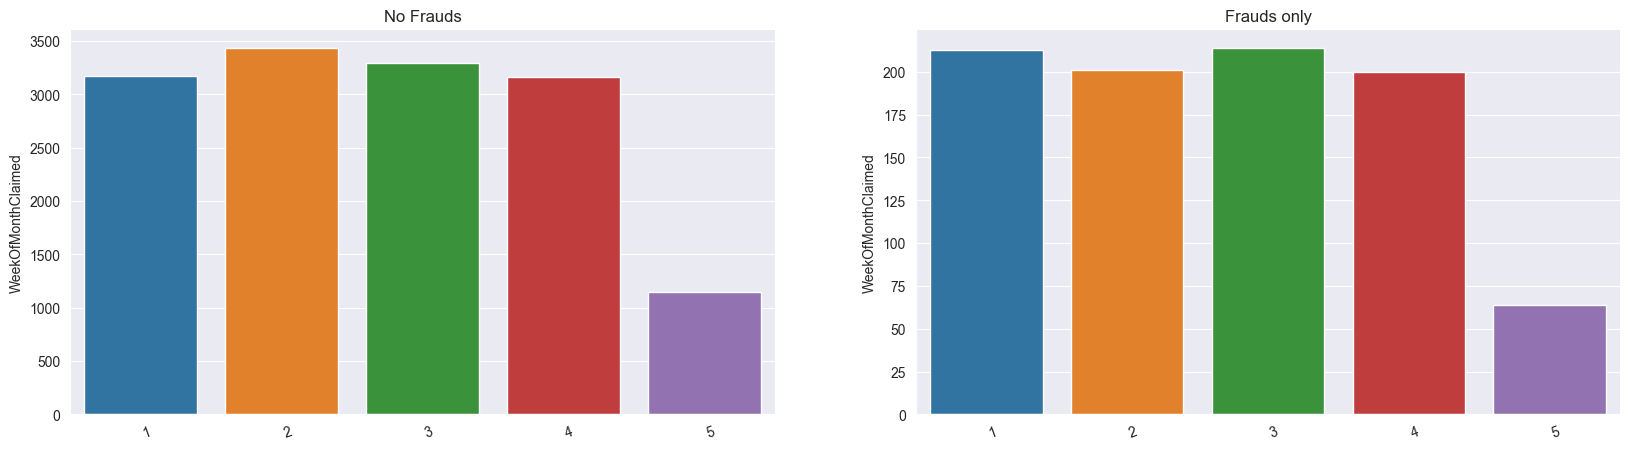

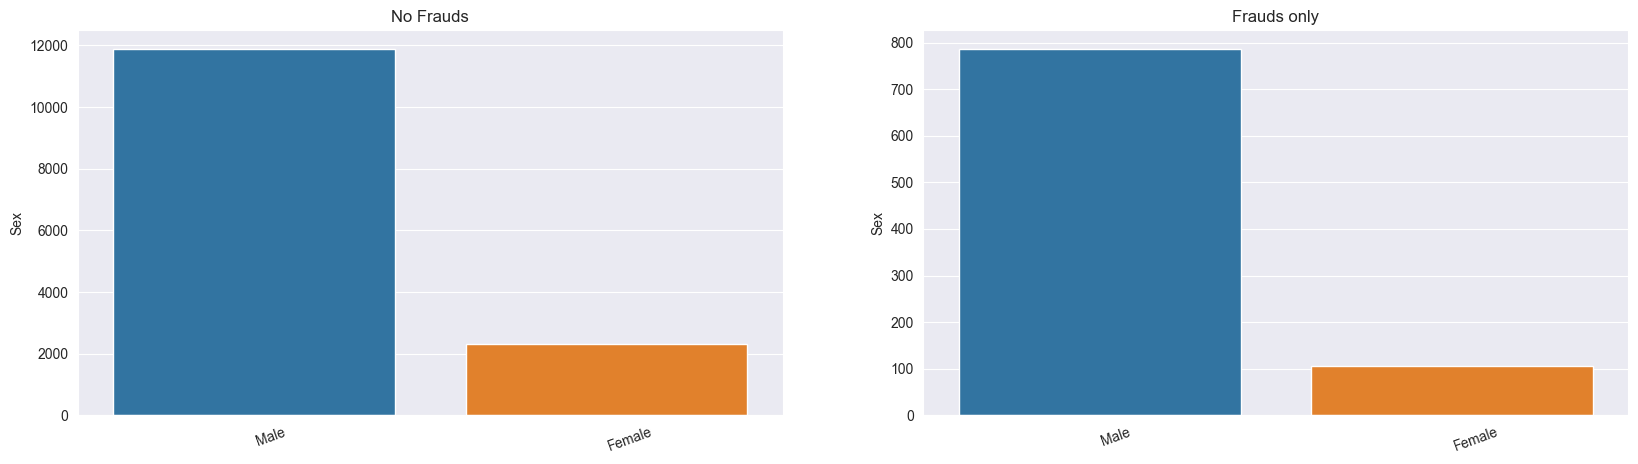

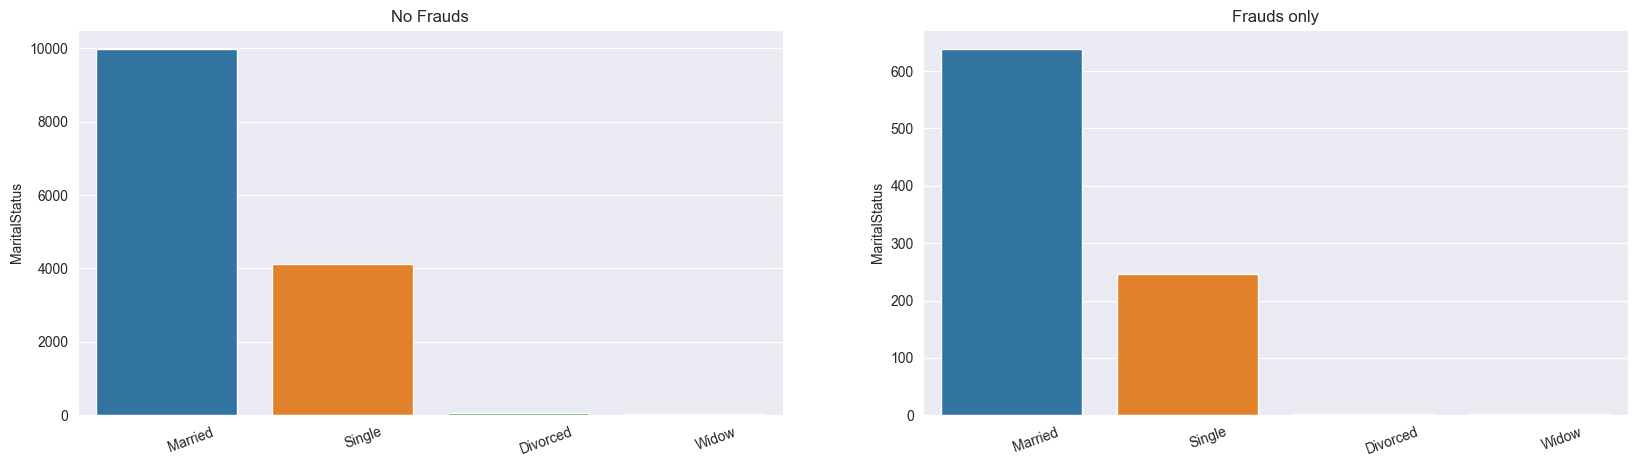

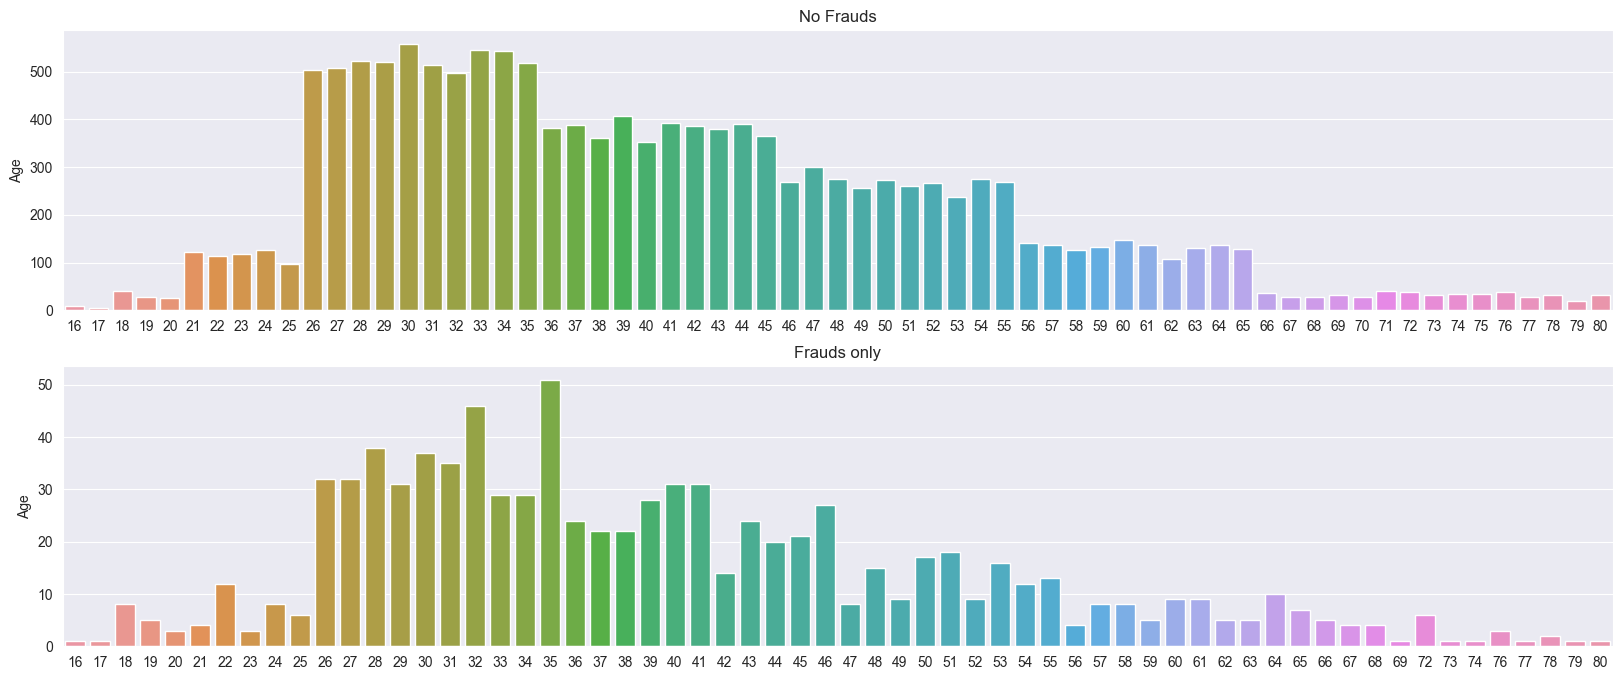

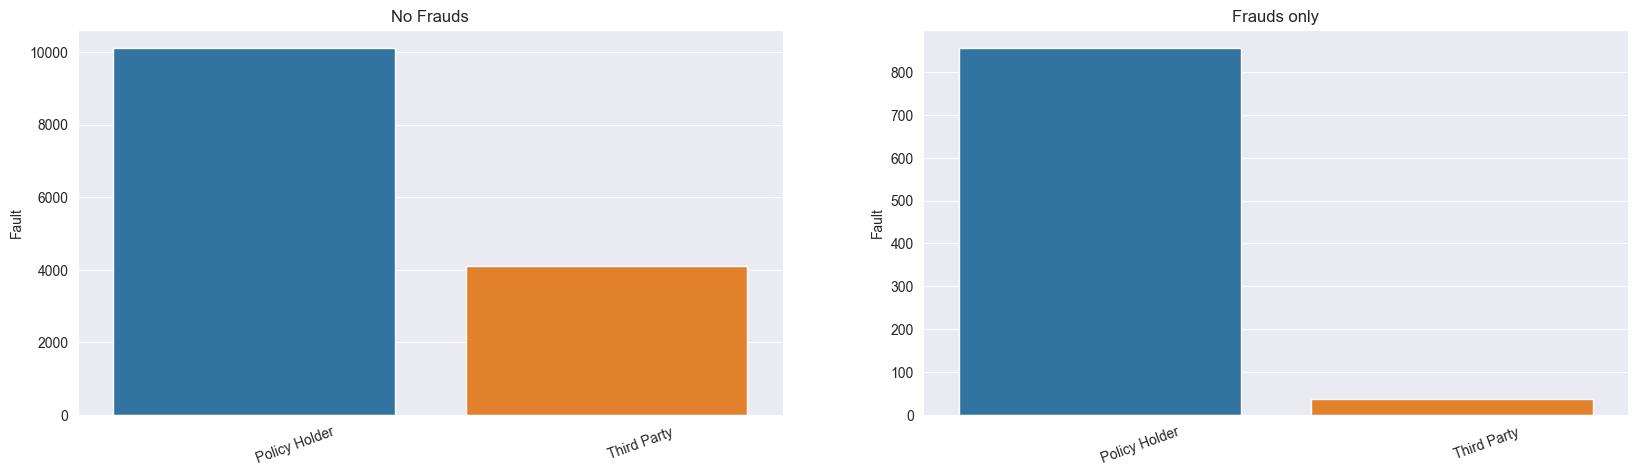

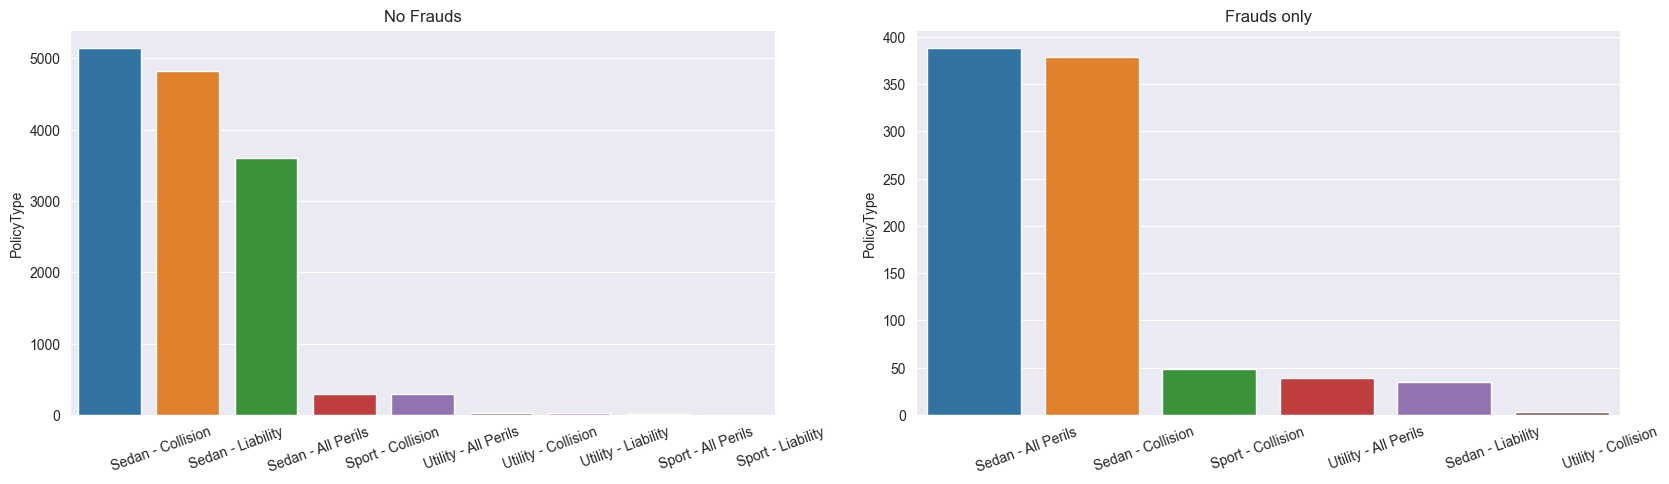

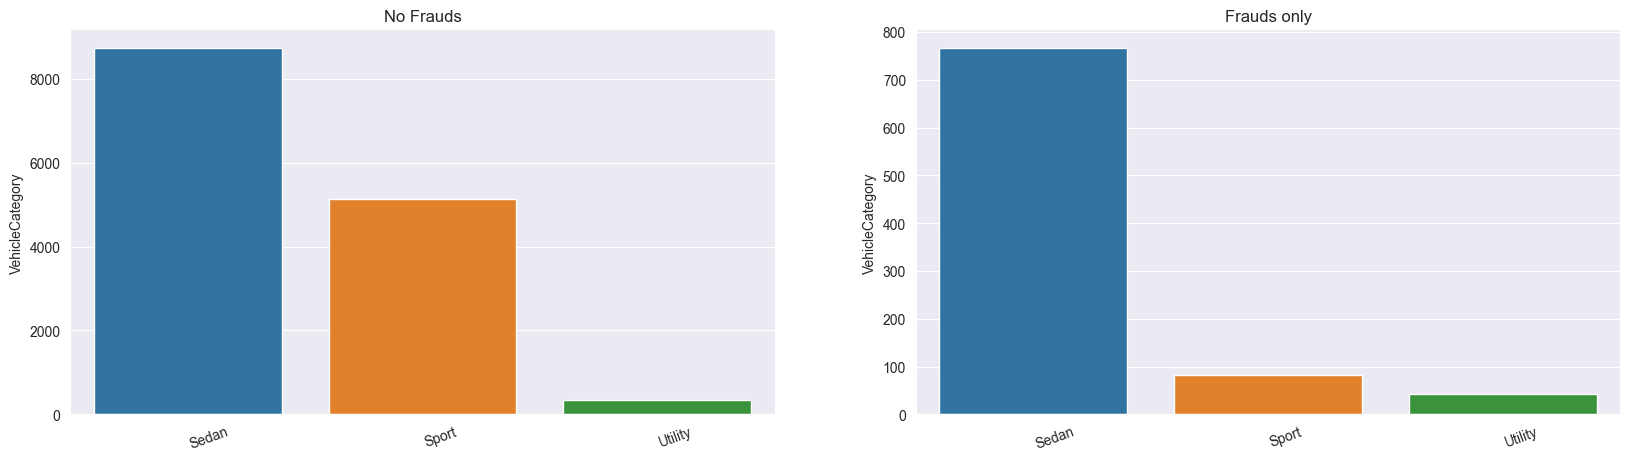

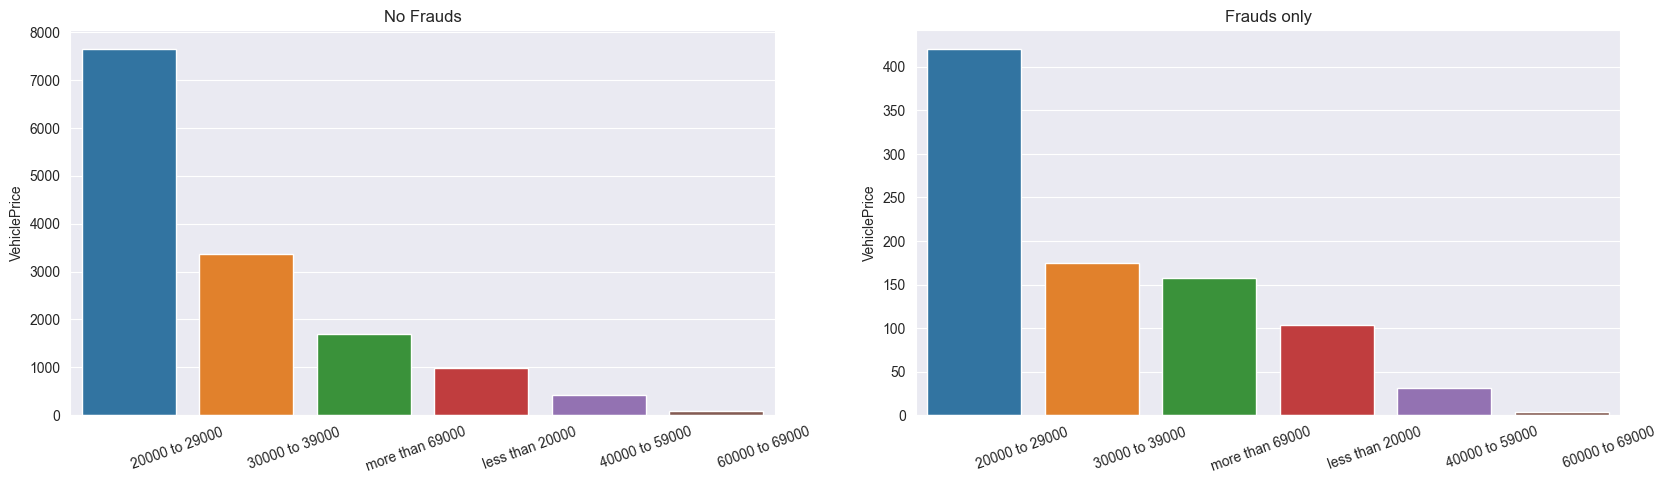

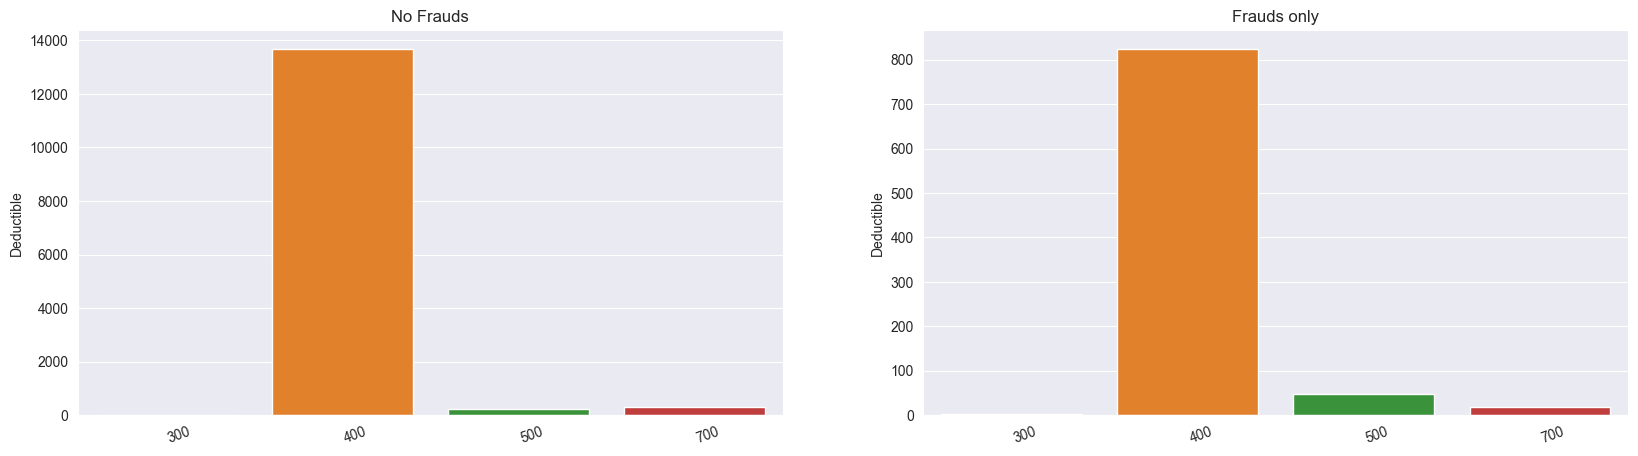

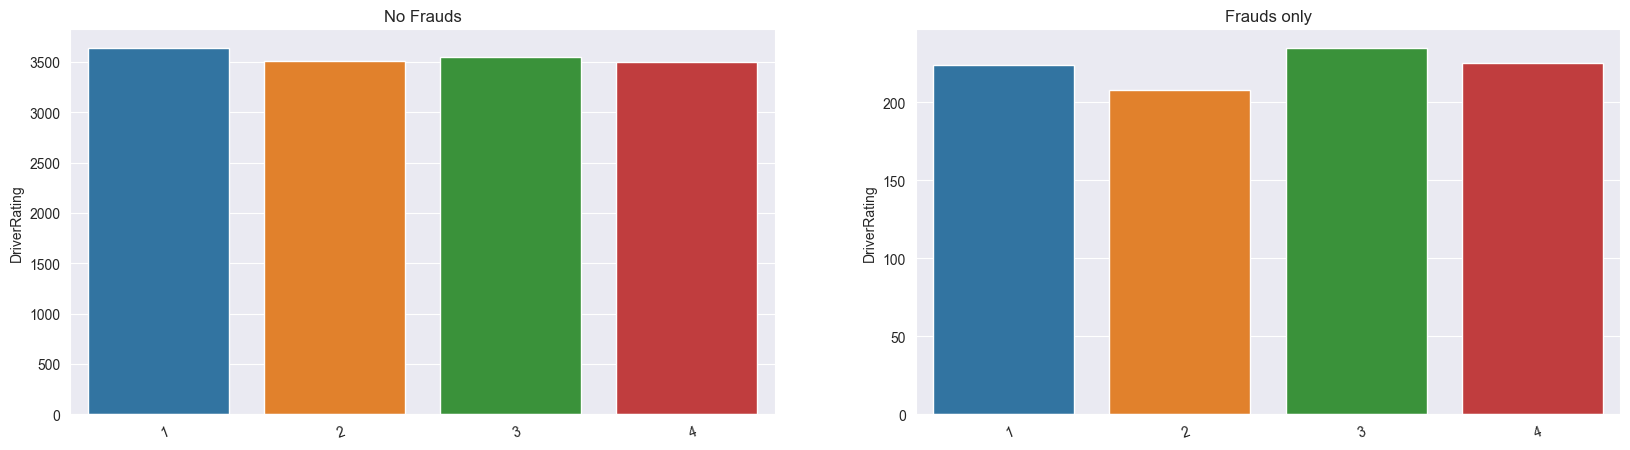

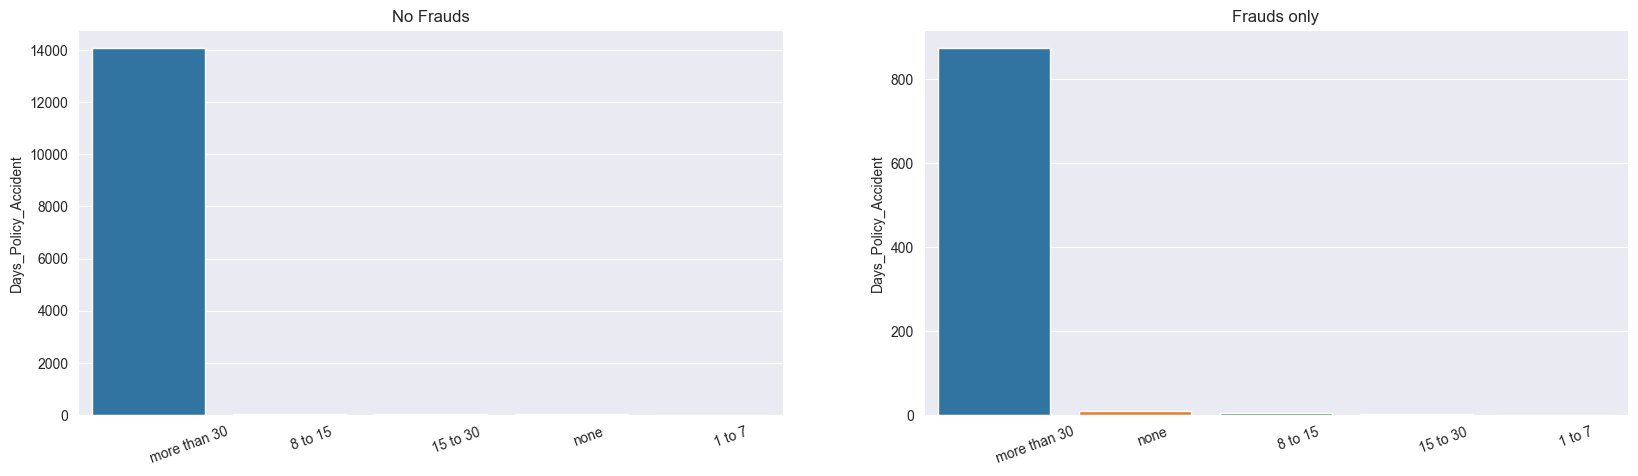

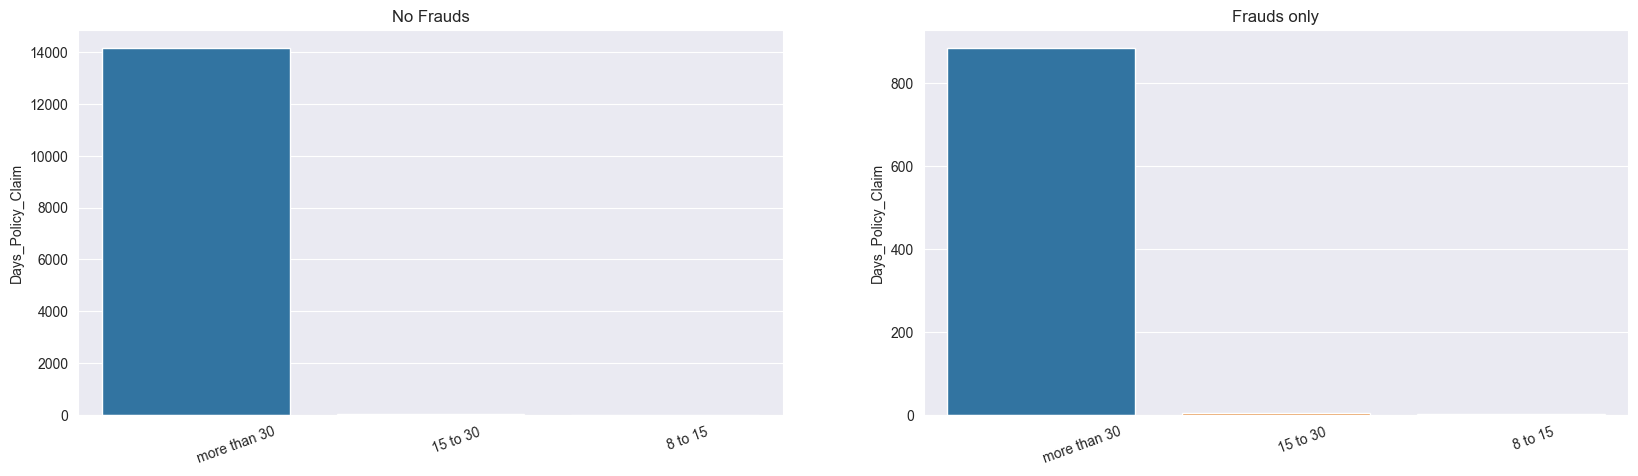

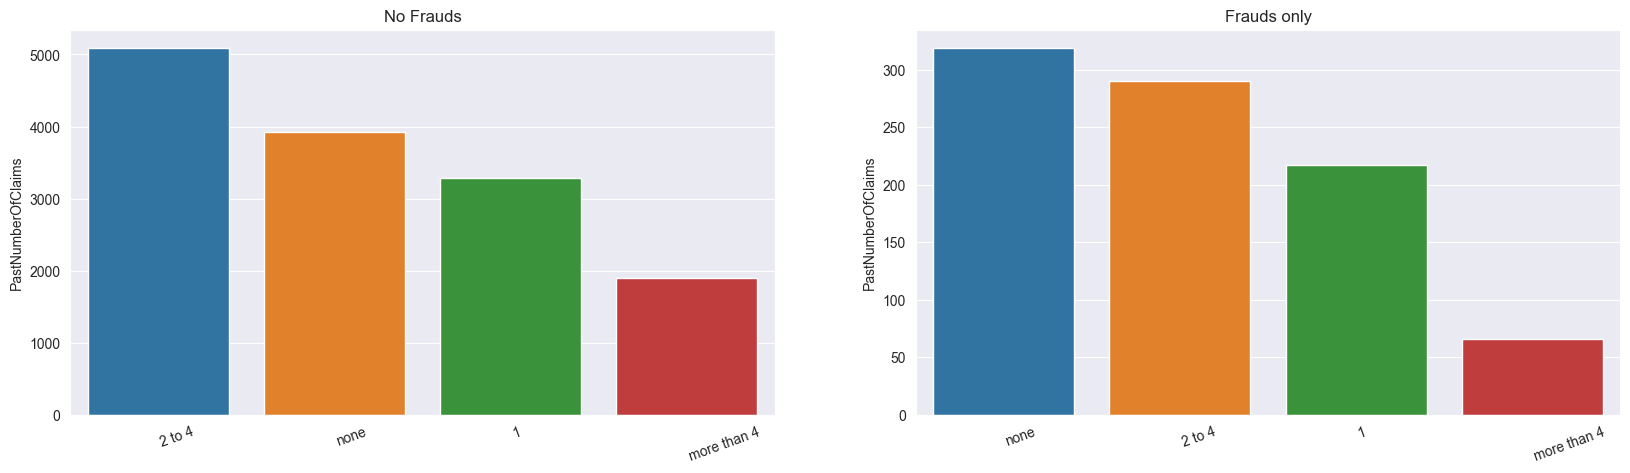

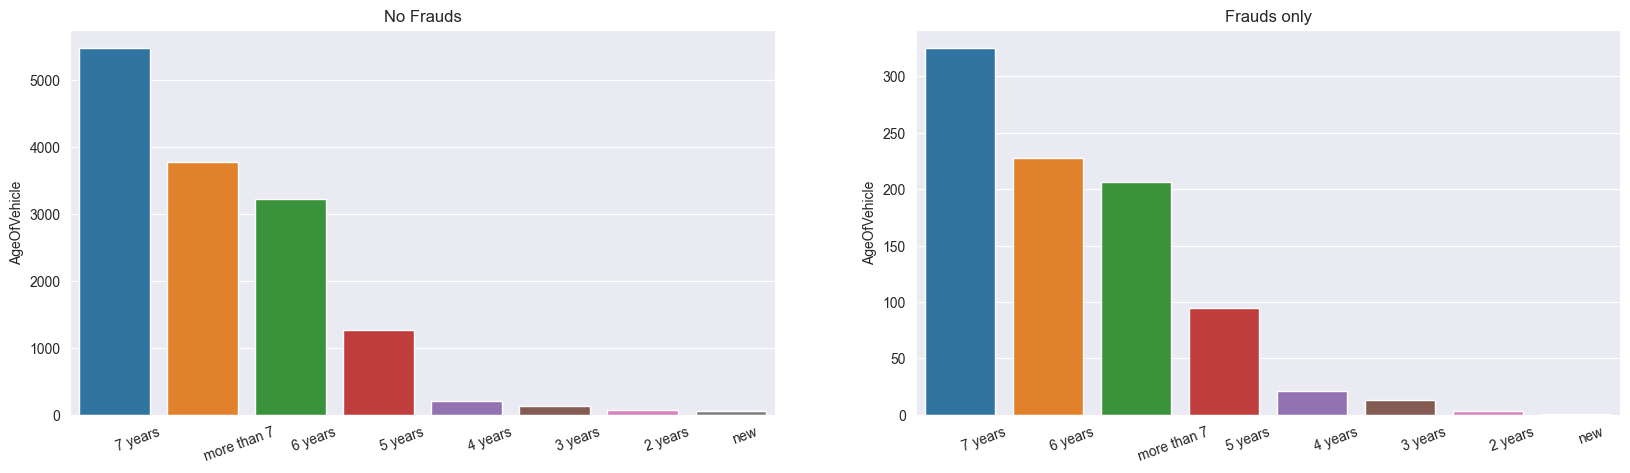

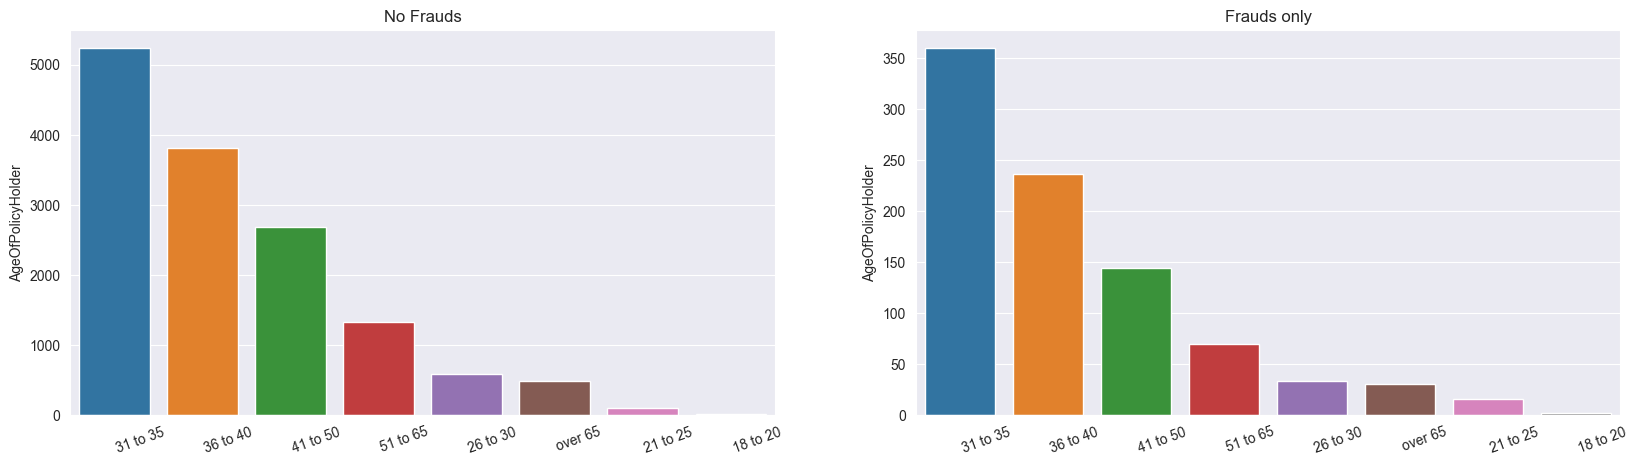

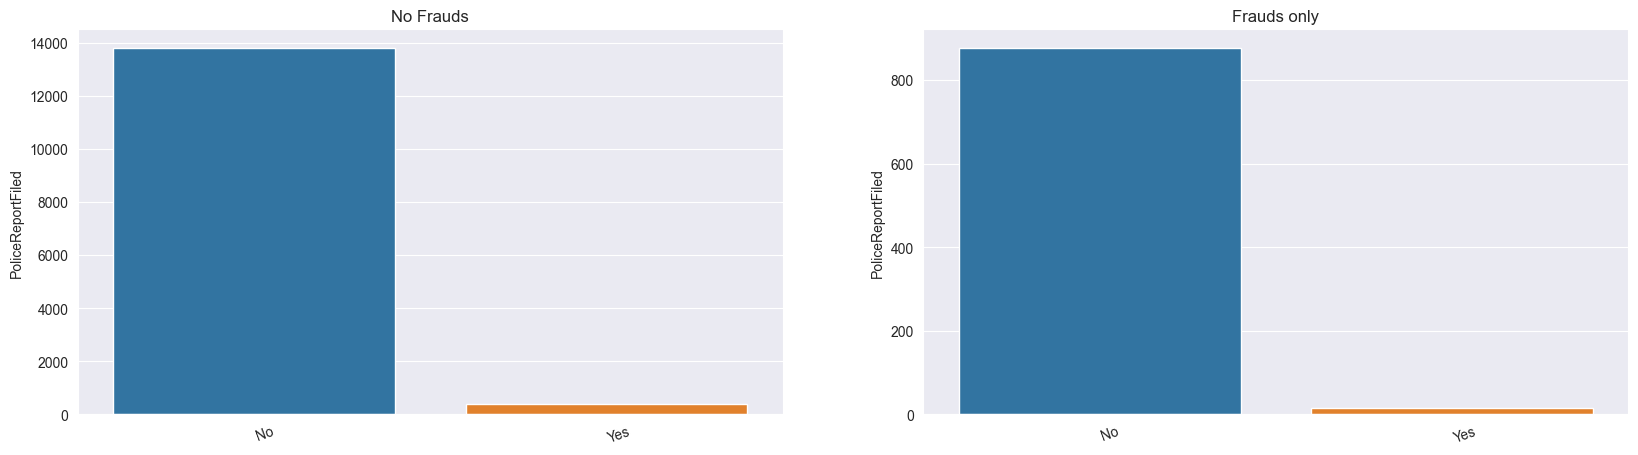

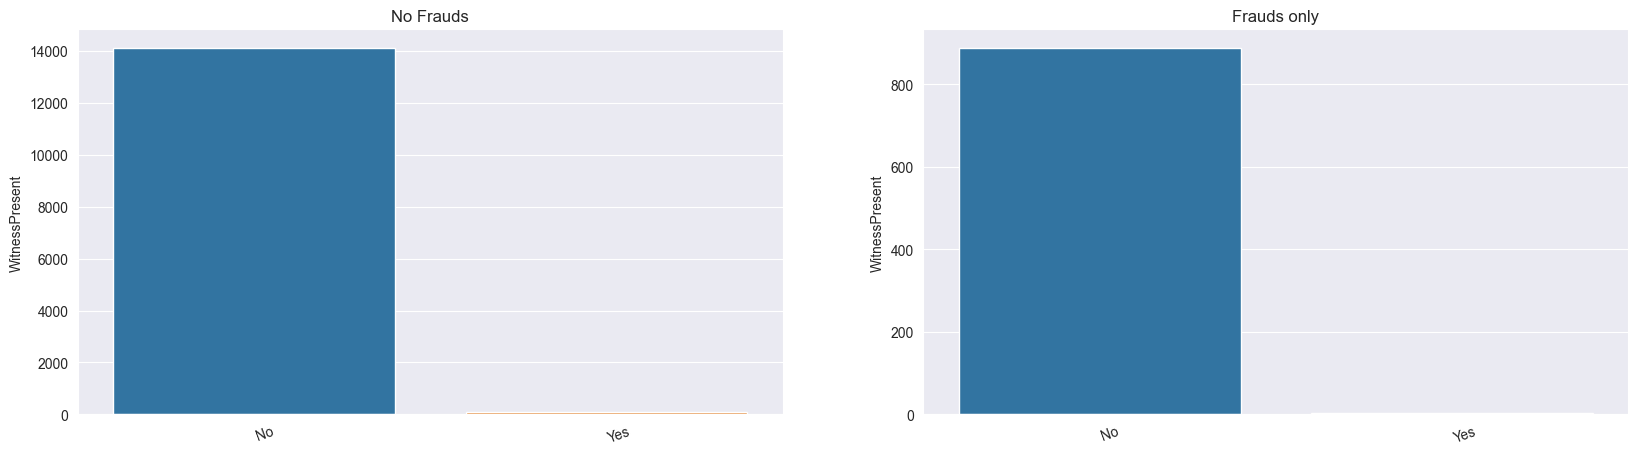

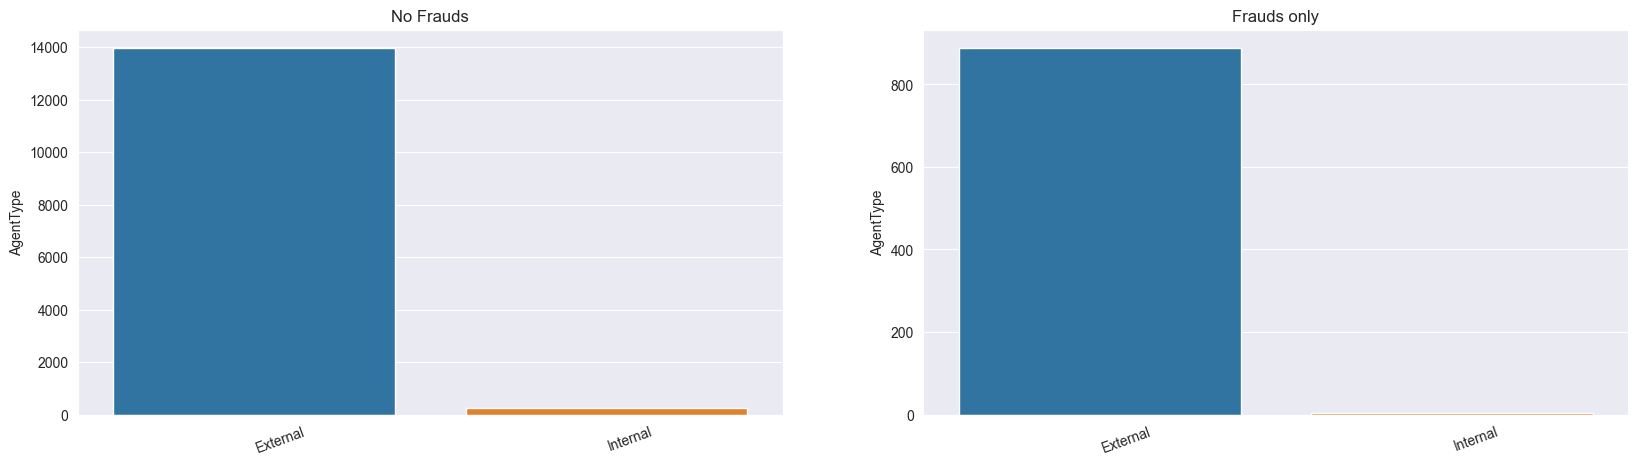

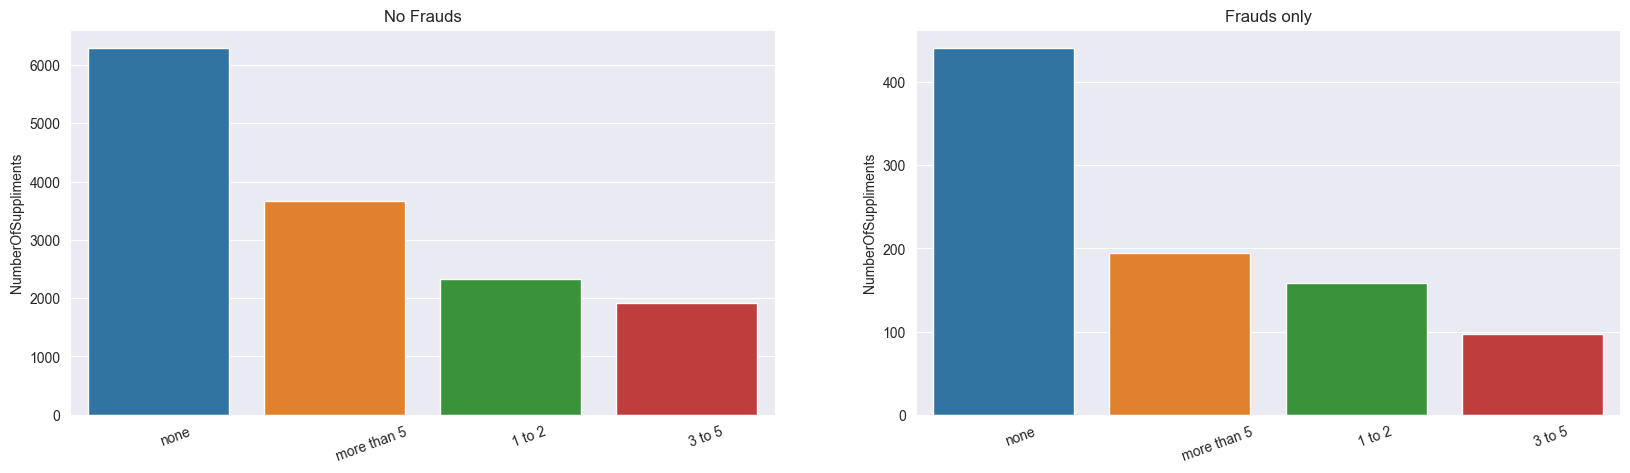

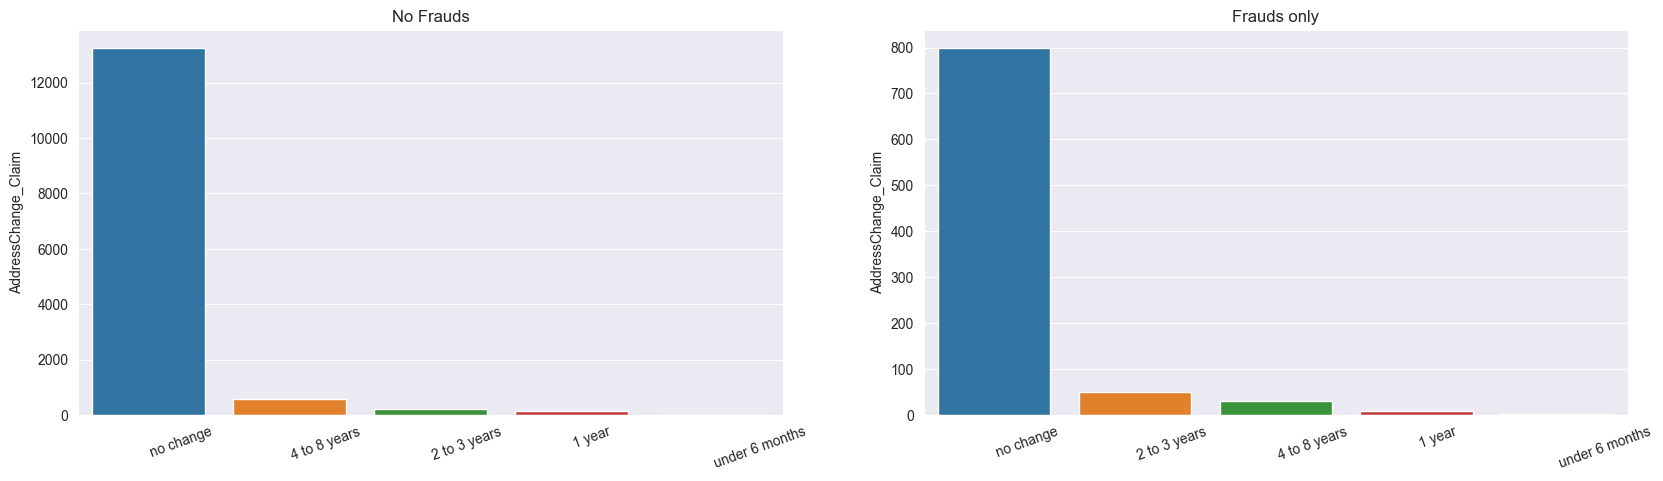

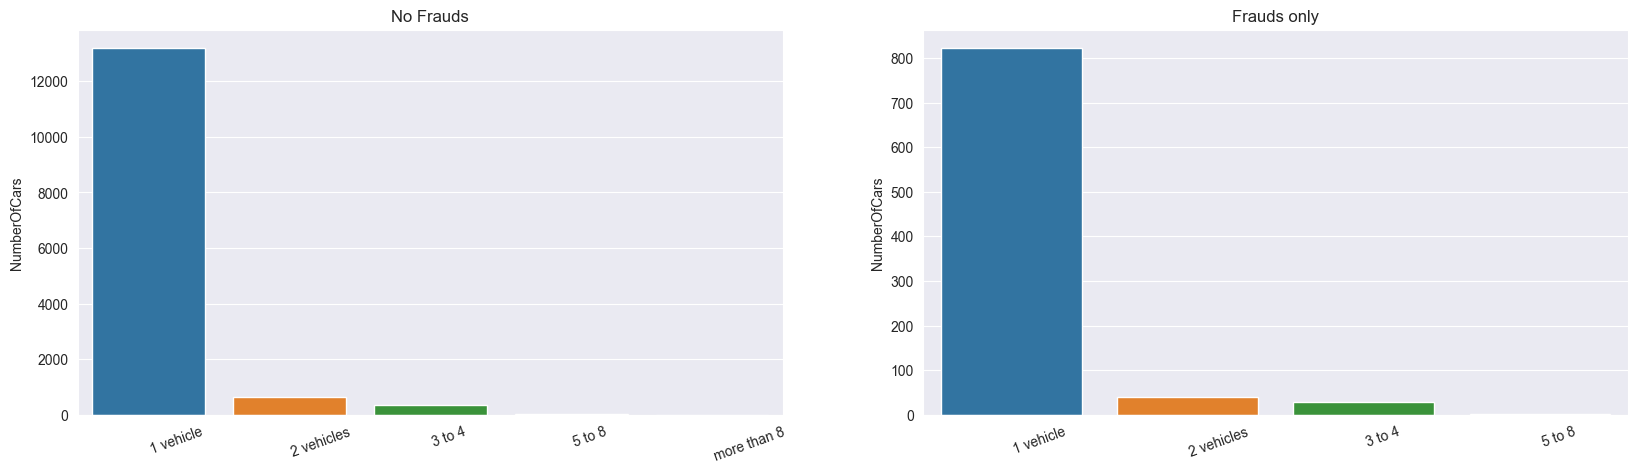

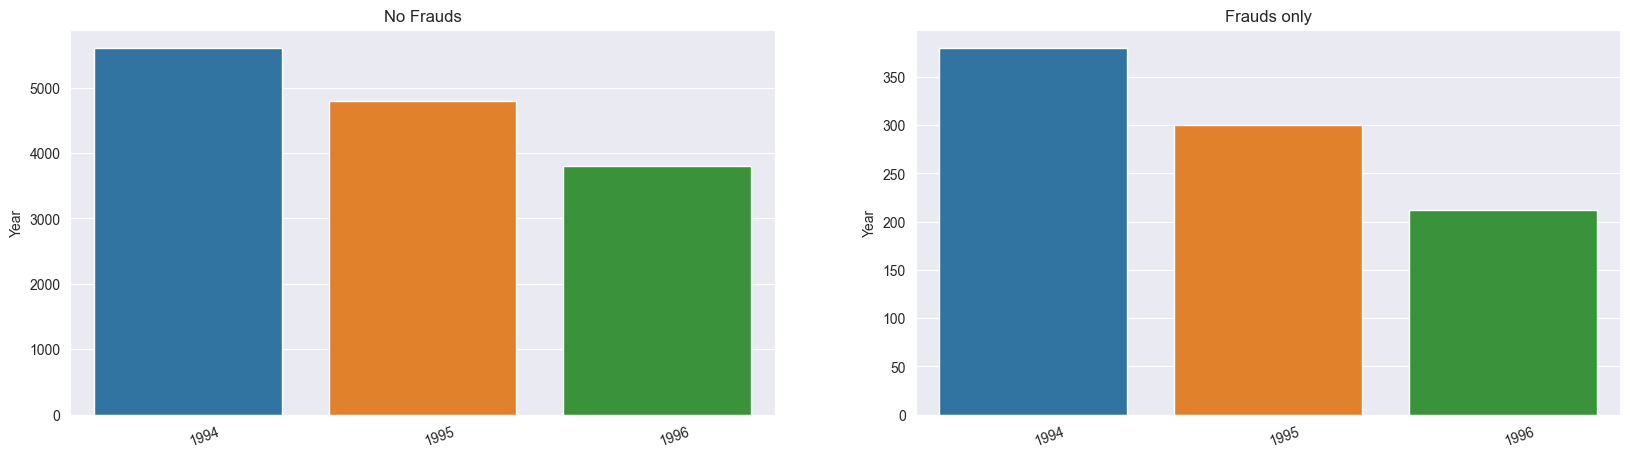

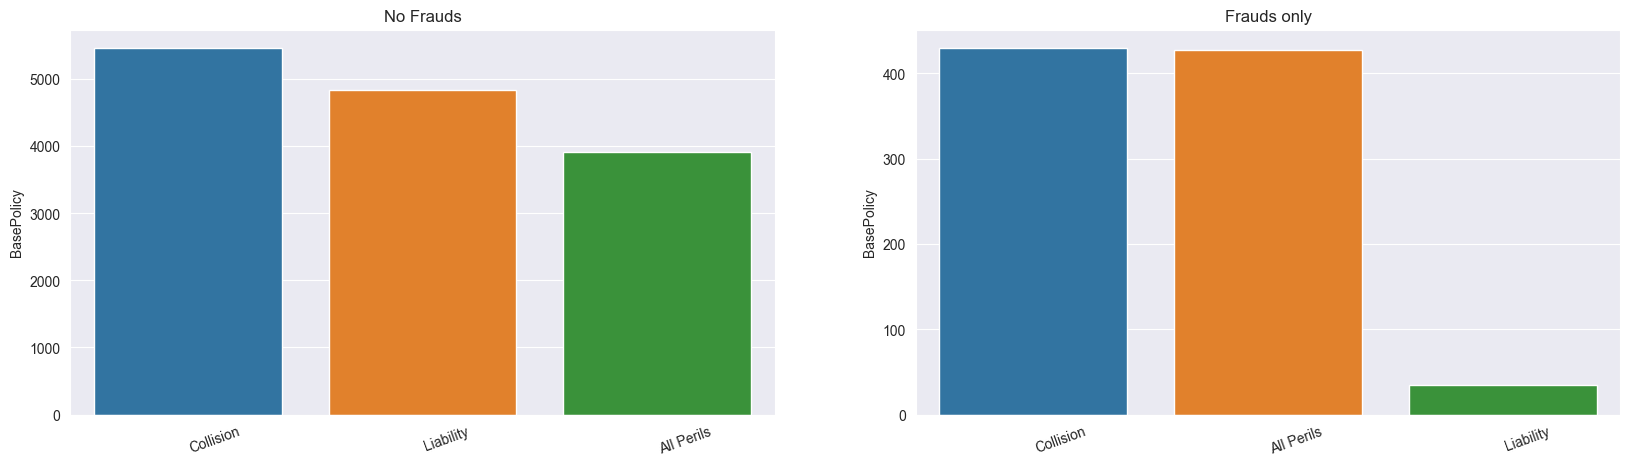

In [19]:
plot_attributes_histograms(data_frame_no_nulls)

**Wnioski z analizy:**
Na postawie analizy powyższych wykresów, w niektórych kolumnach nie widać znaczących zmian statystycznych uwzględniając czy zgłoszenia są oszustwami, czy nie.
Kolumny, w których nie widać praktycznie żadnych zmian to:
* MartialStatus
* DayOfWeekClaimed (questionable at best)
* WeekOfMonthClaimed
* Sex
* DriverRating
* Days_Policy_Accident
* Days_Policy_Claim
* AgeOfPolicyHolder
* AgentType
* NumberOfSuppliments
* NumberOfCars
* Year

Jest też wiele cech, które zmieniają się na w na tyle niewielkim stopniu, że mogą być one spowodowane jedynie zbyt małą ilością naszych danych. Są to kolumny:
* WeekOfMonth
* PoliceReportFiled
* WitnessPresent

Przeanalizujemy teraz wszystkie atrybuty, które mają związek z dniami i miesiącami. Dodajemy je w osobnym miejscu dla wygodniejszej analizy.

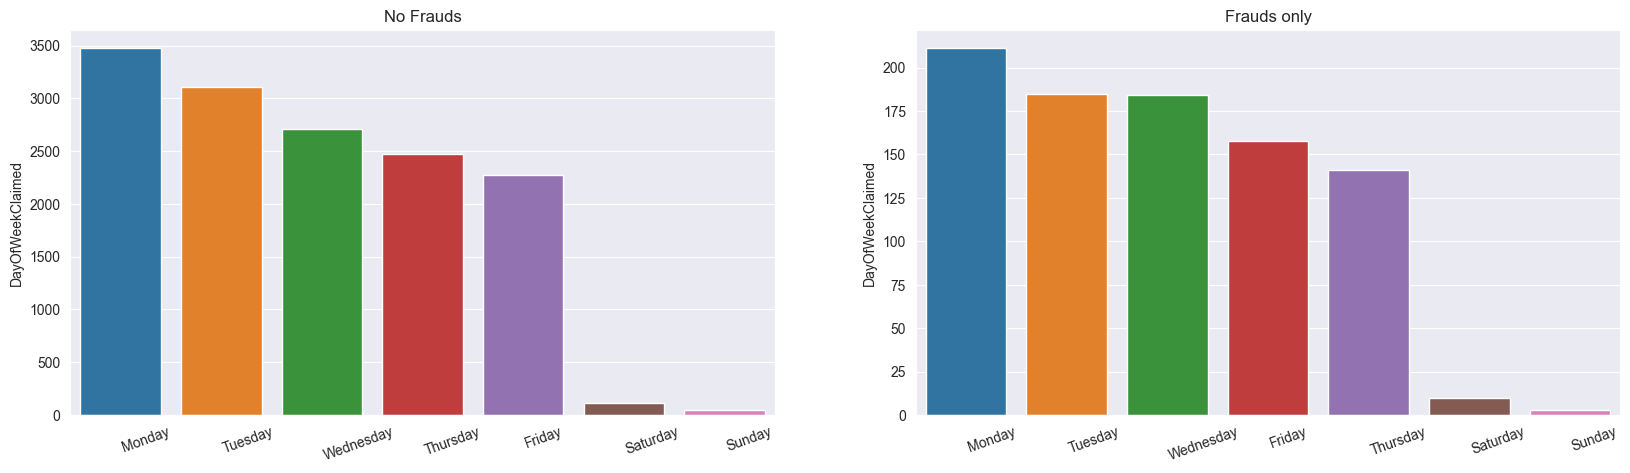

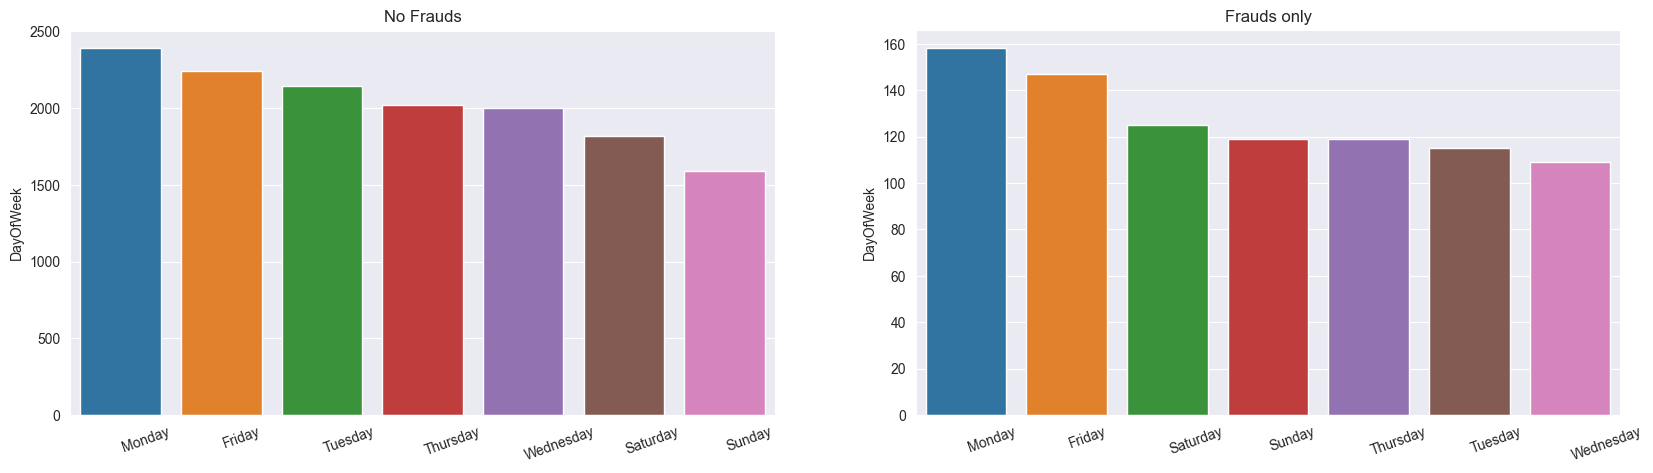

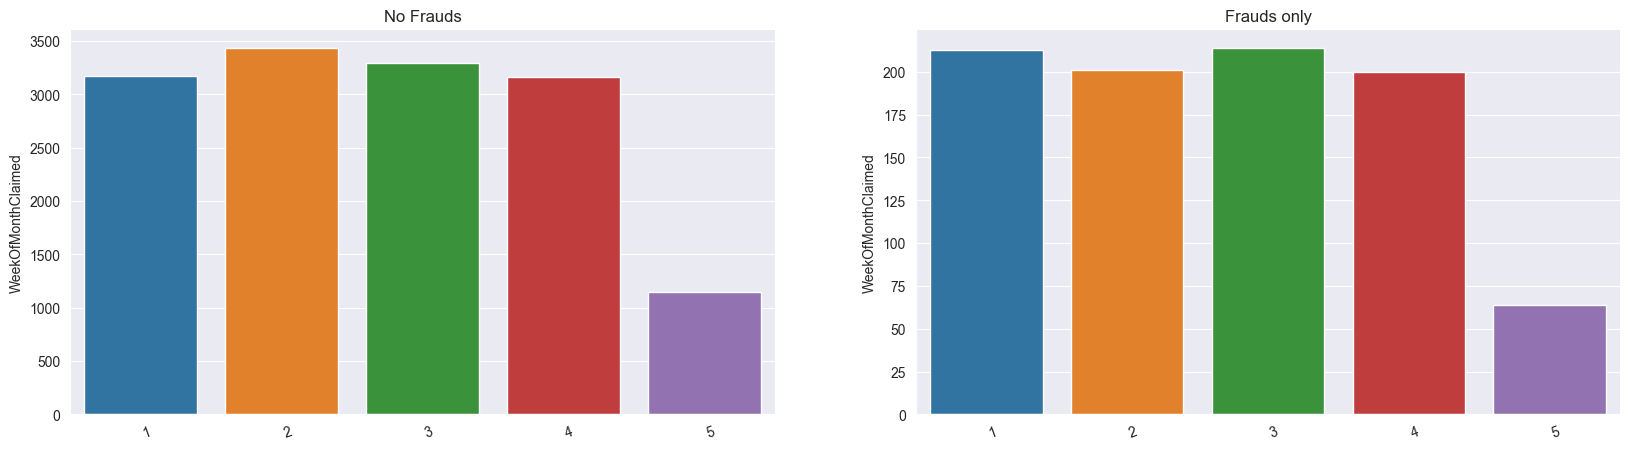

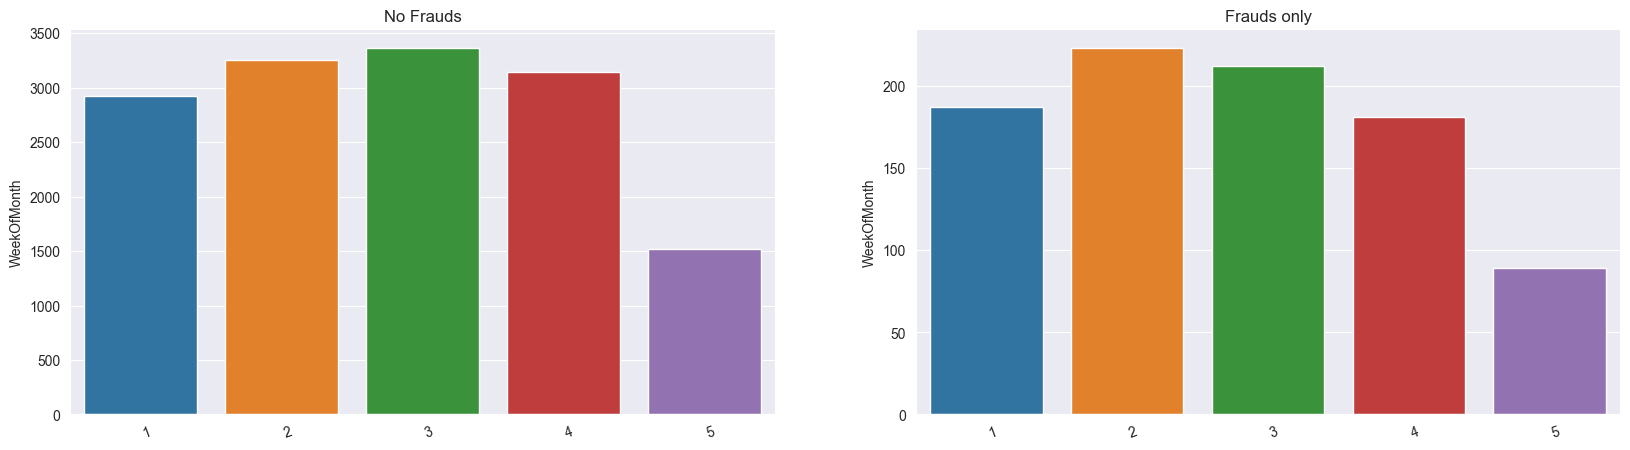

In [20]:
of_weeks: list[str] = ["DayOfWeekClaimed", "DayOfWeek", "WeekOfMonthClaimed", "WeekOfMonth"]

for of_week in of_weeks:
    plot_comparison_bar_plots(data_frame_no_nulls, of_week)

*Wnioski z wykresów*:
* Nie widać korelacji występowania wyłudzeń w zależności od dni i miesięcy

Usuniemy teraz kolumny, które nie dają nam dobrego rozróżnienia na wyłudzenia i ich brak, a powstałą w wyniku tej operacji ramkę danych zapiszemy w nowej.

In [21]:
columns_to_drop: list[str] = ["MaritalStatus", "Sex", "DriverRating", "Days_Policy_Claim", "Days_Policy_Accident",
                              "AgeOfPolicyHolder", "PoliceReportFiled", "WitnessPresent", "AgentType", "NumberOfSuppliments",
                              "NumberOfCars", "Year", "WeekOfMonth", "WeekOfMonthClaimed"]

dropped_frame: pd.DataFrame = data_frame_no_nulls.drop(columns=columns_to_drop)

dropped_frame

,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,Deductible,PastNumberOfClaims,AgeOfVehicle,AddressChange_Claim,BasePolicy
0,Dec,Wednesday,Honda,Urban,Tuesday,Jan,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,300,none,3 years,1 year,Liability
1,Jan,Wednesday,Honda,Urban,Monday,Jan,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,400,none,6 years,no change,Collision
2,Oct,Friday,Honda,Urban,Thursday,Nov,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,400,1,7 years,no change,Collision
3,Jun,Saturday,Toyota,Rural,Friday,Jul,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,400,1,more than 7,no change,Liability
4,Jan,Monday,Honda,Urban,Tuesday,Feb,27,Third Party,Sport - Collision,Sport,more than 69000,0,400,none,5 years,no change,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,Friday,Toyota,Urban,Tuesday,Nov,35,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,400,2 to 4,6 years,no change,Collision
15416,Nov,Thursday,Pontiac,Urban,Friday,Dec,30,Policy Holder,Sedan - Liability,Sport,30000 to 39000,0,400,more than 4,6 years,no change,Liability
15417,Nov,Thursday,Toyota,Rural,Friday,Dec,24,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,400,more than 4,5 years,no change,Collision
15418,Dec,Monday,Toyota,Urban,Thursday,Dec,34,Third Party,Sedan - All Perils,Sedan,20000 to 29000,0,400,none,2 years,no change,All Perils


Teraz sprawdzimy jak zmieniły się parametry ramki po usunięciu kolumn.

In [22]:
describe_frame(dropped_frame)

Number of Objects : 15100
Number of attributes : 17
Number of missing objects : 0

Class : NotFraud
	Num Of Objects : 14208
Class : Fraud
	Num Of Objects : 892


Jak widzimy liczba atrybutów teraz wynosi już tylko 17.

Zdefiniujemy dwie nowe funkcje *group_uniques_strings_to_unique_ints*, która przekonwertuje nam wszystkie wartości w ramce danych na unikalne wartości liczbowe i *print_unique_dict*, która wypisze nam powstały słownik w czytelny sposób.

In [23]:
def group_uniques_strings_to_unique_ints(frame: pd.DataFrame, column_index: str, dictionary: dict) -> None:
    """
    Converts column of a frame into int values only
    :param frame: data frame pandas
    :param column_index: column name str
    :param dictionary: dict of value in columns
    :return: None
    """
    for i, value in enumerate(frame[column_index].unique()):
        if isinstance(value, np.int64):
            return
        dictionary[value] = i

    frame[column_index] = frame[[column_index]].applymap(lambda x: dictionary[x])


def print_unique_dict(unique_dict: dict) -> None:
    """
    Prints data of a unique dict of dicts
    :param unique_dict: dict of unique values
    :return: None
    """
    for column in unique_dict:
        print(f"Column: {column}")
        print(f"\tDict :\n\t\t{unique_dict[column]}\n")

Naszym następnym krokiem jest utworzenie nowej ramki danych, która będzie posiadała wszystkie wartości ramki *dropped_frame*, ale przekonwertowane na unikalne wartości liczbowe. Wyświetlimy tutaj również w jaki sposób wartości te zostały zamienione poprzez pokazanie wykorzystanego słownika i wyświetlimy powstałą ramkę.

In [24]:
unique_frame: pd.DataFrame = dropped_frame.copy()

uniques_dict: dict = {}

for column in unique_frame.columns:
    column_dict: dict = {}

    group_uniques_strings_to_unique_ints(unique_frame, column, column_dict)

    uniques_dict[column] = column_dict
print_unique_dict(uniques_dict)

unique_frame

Column: Month
	Dict :
		{'Dec': 0, 'Jan': 1, 'Oct': 2, 'Jun': 3, 'Feb': 4, 'Apr': 5, 'Mar': 6, 'Aug': 7, 'Jul': 8, 'May': 9, 'Sep': 10, 'Nov': 11}

Column: DayOfWeek
	Dict :
		{'Wednesday': 0, 'Friday': 1, 'Saturday': 2, 'Monday': 3, 'Tuesday': 4, 'Sunday': 5, 'Thursday': 6}

Column: Make
	Dict :
		{'Honda': 0, 'Toyota': 1, 'Ford': 2, 'Mazda': 3, 'Chevrolet': 4, 'Pontiac': 5, 'Accura': 6, 'Dodge': 7, 'Mercury': 8, 'Jaguar': 9, 'Nisson': 10, 'VW': 11, 'Saab': 12, 'Saturn': 13, 'Porche': 14, 'BMW': 15, 'Mecedes': 16, 'Ferrari': 17, 'Lexus': 18}

Column: AccidentArea
	Dict :
		{'Urban': 0, 'Rural': 1}

Column: DayOfWeekClaimed
	Dict :
		{'Tuesday': 0, 'Monday': 1, 'Thursday': 2, 'Friday': 3, 'Wednesday': 4, 'Saturday': 5, 'Sunday': 6}

Column: MonthClaimed
	Dict :
		{'Jan': 0, 'Nov': 1, 'Jul': 2, 'Feb': 3, 'Dec': 4, 'Apr': 5, 'Mar': 6, 'Aug': 7, 'May': 8, 'Jun': 9, 'Sep': 10, 'Oct': 11}

Column: Age
	Dict :
		{}

Column: Fault
	Dict :
		{'Policy Holder': 0, 'Third Party': 1}

Column: Poli

,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,Deductible,PastNumberOfClaims,AgeOfVehicle,AddressChange_Claim,BasePolicy
0,0,0,0,0,0,0,21,0,0,0,0,0,300,0,0,0,0
1,1,0,0,0,1,0,34,0,1,0,0,0,400,0,1,1,1
2,2,1,0,0,2,1,47,0,1,0,0,0,400,1,2,1,1
3,3,2,1,1,3,2,65,1,2,0,1,0,400,1,3,1,0
4,1,3,0,0,0,3,27,1,1,0,0,0,400,0,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,11,1,1,0,0,1,35,0,5,2,1,1,400,2,1,1,1
15416,11,6,5,0,3,4,30,0,2,0,2,0,400,3,1,1,0
15417,11,6,1,1,3,4,24,0,5,2,1,1,400,3,4,1,1
15418,0,3,1,0,2,4,34,1,4,2,1,0,400,0,6,1,2


Dla sprawdzenia zależności atrybutów od siebie wyświetlimy teraz macierz korelacji w postaci mapy ciepła dla powstałem ramki danych.

<AxesSubplot: >

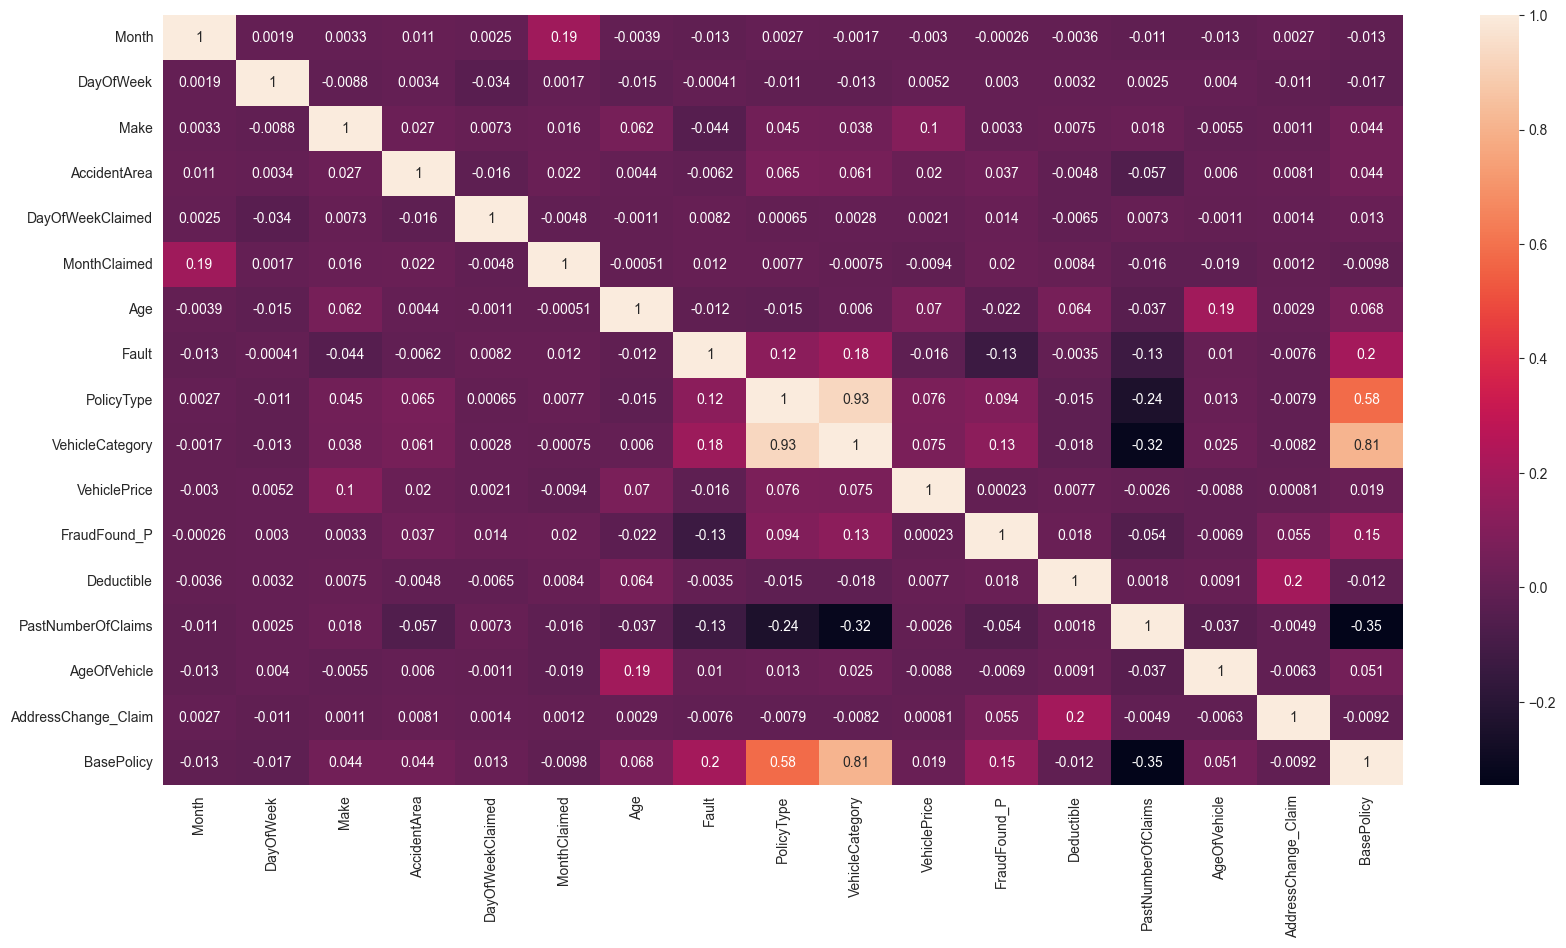

In [25]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=unique_frame.corr(), annot=unique_frame.corr())

Wnioski z heatmapy:
* VehicleCategory jest silnie skorelowany z atrybutem PolicyType
* BasePolicy jest aż w 81% skorelowany z PolicyType a co za tym idzie również z VehicleCategory
* Atrybuty Month, DayOfWeek, Make, VehiclePrice, AgeOfVehicle są bardzo nisko skorelowany (w tysięcznych częściach)
* Atrybuty AddressChange_Claim, AccidentArea, DayOfWeekClaimed, MonthClaimed, Age, Deductible, PastNumberOfClaims są ze sobą skorelowane w dziesiątych częściach.
* Najlepiej skorelowanymi atrybutami z klasą FraudFound_P są atrybuty Fault, PolicyType, VehicleCategory i BasePolicy

Bazując na zdobytej wiedzy z analizy heatmapy usuniemy najmniej przydatne atrybuty i utworzymy nową ramkę posiadającą tylko najlepsze do klasyfikacji atrybuty.

In [26]:
attributes_list_1: list[str] = ["Month", "DayOfWeek", "Make", "VehiclePrice", "AgeOfVehicle"]

best_attributes_frame: pd.DataFrame = unique_frame.drop(columns=attributes_list_1)

best_attributes_frame

,AccidentArea,DayOfWeekClaimed,MonthClaimed,Age,Fault,PolicyType,VehicleCategory,FraudFound_P,Deductible,PastNumberOfClaims,AddressChange_Claim,BasePolicy
0,0,0,0,21,0,0,0,0,300,0,0,0
1,0,1,0,34,0,1,0,0,400,0,1,1
2,0,2,1,47,0,1,0,0,400,1,1,1
3,1,3,2,65,1,2,0,0,400,1,1,0
4,0,0,3,27,1,1,0,0,400,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15415,0,0,1,35,0,5,2,1,400,2,1,1
15416,0,3,4,30,0,2,0,0,400,3,1,0
15417,1,3,4,24,0,5,2,1,400,3,1,1
15418,0,2,4,34,1,4,2,0,400,0,1,2


##  Klasyfikacja
*Po wykonaniu eksploracji danych zbioru dokonując wizualizacji oraz badając wartości poszczególnych atrybutów ilościowych, oraz zależności liniowe atrybutów między sobą jesteśmy w stanie przejść do klasyfikacji. Klasyfikacja polega tutaj na znalezieniu odpowiedniego modelu, który na wejściu dostanie odpowiednie zgłoszenie oraz na wyjściu zaklasyfikuje z największą poprawnością czy dany obiekt jest oszustwem, czy nie jest.*

*Początek klasyfikacji:*
> Proces klasyfikacji rozpoczynamy od podziału zbioru naszych danych na zbiór danych uczących oraz zbiór danych testowych. Zbiory te potrzebne nam będą przy użyciu odpowiednich klasyfikatorów oraz do sprawdzenia poprawności działania klasyfikatora. Zbiory są podzielone w zakresie 30% na zbiór danych testowych oraz 70% na zbiór danych uczących, tak jest to zalecane.

> Ważne jest to, że do budowy modelu użyjemy najlepszych atrybutów, które zostały wyłonione podczas analizy eksploracyjnej zbioru danych.

In [27]:
def divide_data(frame: pd.DataFrame, wanted_train_size: float) -> dict[str, pd.DataFrame]:
    """
    Function to divide data into train data and predict data
    :param frame: data_frame object from pandas library
    :param wanted_train_size: it is a float number, which evaluates how many objects will be in train data set
    :return: answer_map which contains divided testing set and train set
    """
    x: pd.DataFrame = frame.drop(columns='FraudFound_P')
    y: pd.DataFrame = frame['FraudFound_P']

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=wanted_train_size, random_state=1)

    answer_map: dict[str, pd.DataFrame] = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test}

    return answer_map

Dokonamy teraz podziału na zbiory uczący i testowy wykorzystując naszą funkcję *divide_data*, a następnie wyświetlimy ich rozmiar.

In [42]:
train_size: float = 0.7

divided_data: dict[str, pd.DataFrame] = divide_data(best_attributes_frame, train_size)

print(f'Number of objects for learning set: {divided_data["x_train"].shape[0]}')
print(f'Number of objects for test set: {divided_data["x_test"].shape[0]}')

Number of objects for learning set: 10570
Number of objects for test set: 4530


*Dalsze kroki z klasyfikacją:*
> Po wykonaniu podziału naszego zbioru danych na zbiór uczący oraz testowy jesteśmy w stanie zbudować odpowiedni model do klasyfikacji oszustw ubezpieczeniowych. Funkcja make_prediction przyjmuje odpowiedni model klasyfikatora np. Drzewo decyzyjna oraz dane, czyli atrybuty, na podstawie których będzie robiona klasyfikacja. Na końcu zostaną również wyświetlone metryki i  odpowiednia macierz pomyłek, która mówi nam o pomyłkach wykonanych przez użyty klasyfikator na zbiorze uczącym oraz testowym.

*Metryki to miary skuteczności modelu klasyfikacyjnego. Służą do określenia jak dobrze model rozpoznaje różne klasy. Metryka dokładności (accuracy) to w naszym przypadku za mało, ponieważ rozkład elementów w klasach jest nierównomierny - zdecydowanie więcej jest przypadków bez oszustw. Dlatego dodatkowo zastosowaliśmy metryki:*
>* Czułość (recall) - mierzy procent pozytywnych prognoz w stosunku do wszystkich rzeczywistych pozytywnych przypadków. 
Metryka ta mówi nam, jak często klasyfikator prawidłowo znajduje przypadki wyłudzenia. Jest to ważne, aby uniknąć sytuacji, w której model nie zidentyfikuje wyłudzenia, co byłoby katastrofalne z punktu widzenia ubezpieczyciela.

>* Precyzja (precision) - mierzy procent poprawnych prognoz pozytywnych w stosunku do wszystkich prognoz pozytywnych.
Metryka ta mówi nam, jak często klasyfikator prawidłowo oznacza przypadek jako wyłudzenie. Jest ważne, aby uniknąć sytuacji, w której model będzie oznaczał jako wyłudzenie przypadki, które nimi nie są, co byłoby kosztowne dla ubezpieczyciela.

>* F1-score - jest to średnia harmoniczna precyzji i pełni, daje dobry obraz jakości klasyfikatora, gdy precyzja i czułość są ważne równocześnie.



In [29]:
def make_prediction(prediction_model, data: dict[str, pd.DataFrame]) -> None:
    """
    Function used to make a prediction based on prediction model
    :param prediction_model: model
    :param data: dictionary of names and dataframes
    :return: None
    """
    prediction_model.fit(data['x_train'], data['y_train'])

    train_score = prediction_model.predict(data["x_train"])
    test_score = prediction_model.predict(data["x_test"])

    conf_matrix = confusion_matrix(data["y_train"], train_score)

    print(f"ConfusionMatrix - learning set, accuracy: {prediction_model.score(data['x_train'], data['y_train'])}")
    print(conf_matrix)
    print(classification_report(data["y_train"],train_score, target_names = ['NO FRAUD', 'FRAUD']))
    

    conf_matrix = confusion_matrix(data["y_test"], test_score)

    print(f"ConfusionMatrix - test set, accuracy: {prediction_model.score(data['x_test'], data['y_test'])}")
    print(conf_matrix)
    print(classification_report(data["y_test"], test_score, target_names = ['NO FRAUD', 'FRAUD']))


def test_decision_tree_classifier_for_depth(maximum_depth: int, data: dict[str, pd.DataFrame], start: int = 3, step: int = 1) -> None:
    """
    Function used to try many depths of decision tree classifier for given data.
    :param maximum_depth: int value of max depth of tree
    :param data: dict of pandas Data Frames instance
    :param start: int value of starting depth
    :param step: int value of step between each iteration
    :return: None
    """
    end: int = maximum_depth + 1

    for max_depth in range(start, end, step):
        print(f'Current maximum depth: {max_depth}')

        tree_model: DecisionTreeClassifier = DecisionTreeClassifier(max_depth=max_depth)

        make_prediction(tree_model, data)

        print('---------------------------------------------------\n')

def test_num_of_neighbours_for_knn_classifier(data: dict[str, pd.DataFrame], start: int = 1, num_of_neighbours: int = 5) -> None:
    """
    Function used to test num of neighbours for knn classifier
    :param data: dict of pandas Data Frames instance
    :param start: int value of starting num of neighbours
    :param num_of_neighbours: int value of end num of neighbours
    :return: None
    """
    end: int = num_of_neighbours + 1

    for neighbours_number in range(start, end):
        print(f"Num of neighbours: {neighbours_number}")

        knn: KNeighborsClassifier = KNeighborsClassifier(n_neighbors=neighbours_number)

        make_prediction(knn, data)

        print()
        

*Drzewo decyzyjne:*
> Pierwszym modelem, jaki zostanie użyty przy klasyfikacji jest Drzewo decyzyjna. Drzewo decyzyjne modeluje
zależność decyzyjnego od atrybutów opisujących. Drzewo składa się z węzłów połączonych gałęziami. Węzły reprezentują testy pojedynczych atrybutów, natomiast gałęzie odpowiadają wynikowi poszczególnego testu. Liściem są wyniki klasyfikacji, czyli kategoria.

> Ważnym parametrem drzewa decyzyjnego jest jego maksymalna głębokość. Według wielu portali odnośnie do drzew decyzyjnych udało się określić, że maksymalna głębokość = 16 jest jedną z najlepszych do wykonywania klasyfikacji.

> Mimo tego badanie drzewa decyzyjnego rozdzielimy również na wybór najlepszej maksymalnej głębokości drzewa w celu potwierdzenia tej tezy.

In [36]:
maximum_depth: int = 16

test_decision_tree_classifier_for_depth(maximum_depth, divided_data)

Current maximum depth: 3
ConfusionMatrix - learning set, accuracy: 0.9389782403027436
[[9900   23]
 [ 622   25]]
              precision    recall  f1-score   support

    NO FRAUD       0.94      1.00      0.97      9923
       FRAUD       0.52      0.04      0.07       647

    accuracy                           0.94     10570
   macro avg       0.73      0.52      0.52     10570
weighted avg       0.92      0.94      0.91     10570

ConfusionMatrix - test set, accuracy: 0.9474613686534217
[[4281    4]
 [ 234   11]]
              precision    recall  f1-score   support

    NO FRAUD       0.95      1.00      0.97      4285
       FRAUD       0.73      0.04      0.08       245

    accuracy                           0.95      4530
   macro avg       0.84      0.52      0.53      4530
weighted avg       0.94      0.95      0.92      4530

---------------------------------------------------

Current maximum depth: 4
ConfusionMatrix - learning set, accuracy: 0.9408703878902555
[[9920    

*Wnioski z analizy działania drzewa decyzyjnego:*
> Widzimy, że jeśli chodzi o maksymalną głębokość drzewa decyzyjnego, to zmienia się nam dokładność dla zbioru uczącego oraz zbioru testowego. Najwyższą dokładności dla zbioru testowego otrzymujemy dla mniejszych głębokości drzewa-od 3 do 5. Dla większych głębokości drzewa natomiast mamy bardzo wysoką dokładności dla zbioru uczącego oraz o kilka procent mniejszą dla zbioru testowego.

> Grupa postanowiła wybrać max_depth = 16 za najlepszą głębokość drzewa decyzyjnego. Taka wysokość drzewa daje bardzo dobrą dokładność przy zbiorze uczącym oraz również dobrą, choć nie najlepszą dokładnośc dla zbioru testowego na poziomie 91%.

*Wizualizacja drzewa decyzyjnego:*
> W celu lepszego zapoznania się z najlepszym drzewem decyzyjnym możemy się pokusić o jego wizualizację oraz zobaczyć, jak drzewo wygląda, jakie testy zostały przeprowadzone w poszczególnych węzłach oraz jak dzielił nam się zbiór danych.

ConfusionMatrix - learning set, accuracy: 0.9729422894985809
[[9898   25]
 [ 261  386]]
              precision    recall  f1-score   support

    NO FRAUD       0.97      1.00      0.99      9923
       FRAUD       0.94      0.60      0.73       647

    accuracy                           0.97     10570
   macro avg       0.96      0.80      0.86     10570
weighted avg       0.97      0.97      0.97     10570

ConfusionMatrix - test set, accuracy: 0.9154525386313466
[[4111  174]
 [ 209   36]]
              precision    recall  f1-score   support

    NO FRAUD       0.95      0.96      0.96      4285
       FRAUD       0.17      0.15      0.16       245

    accuracy                           0.92      4530
   macro avg       0.56      0.55      0.56      4530
weighted avg       0.91      0.92      0.91      4530



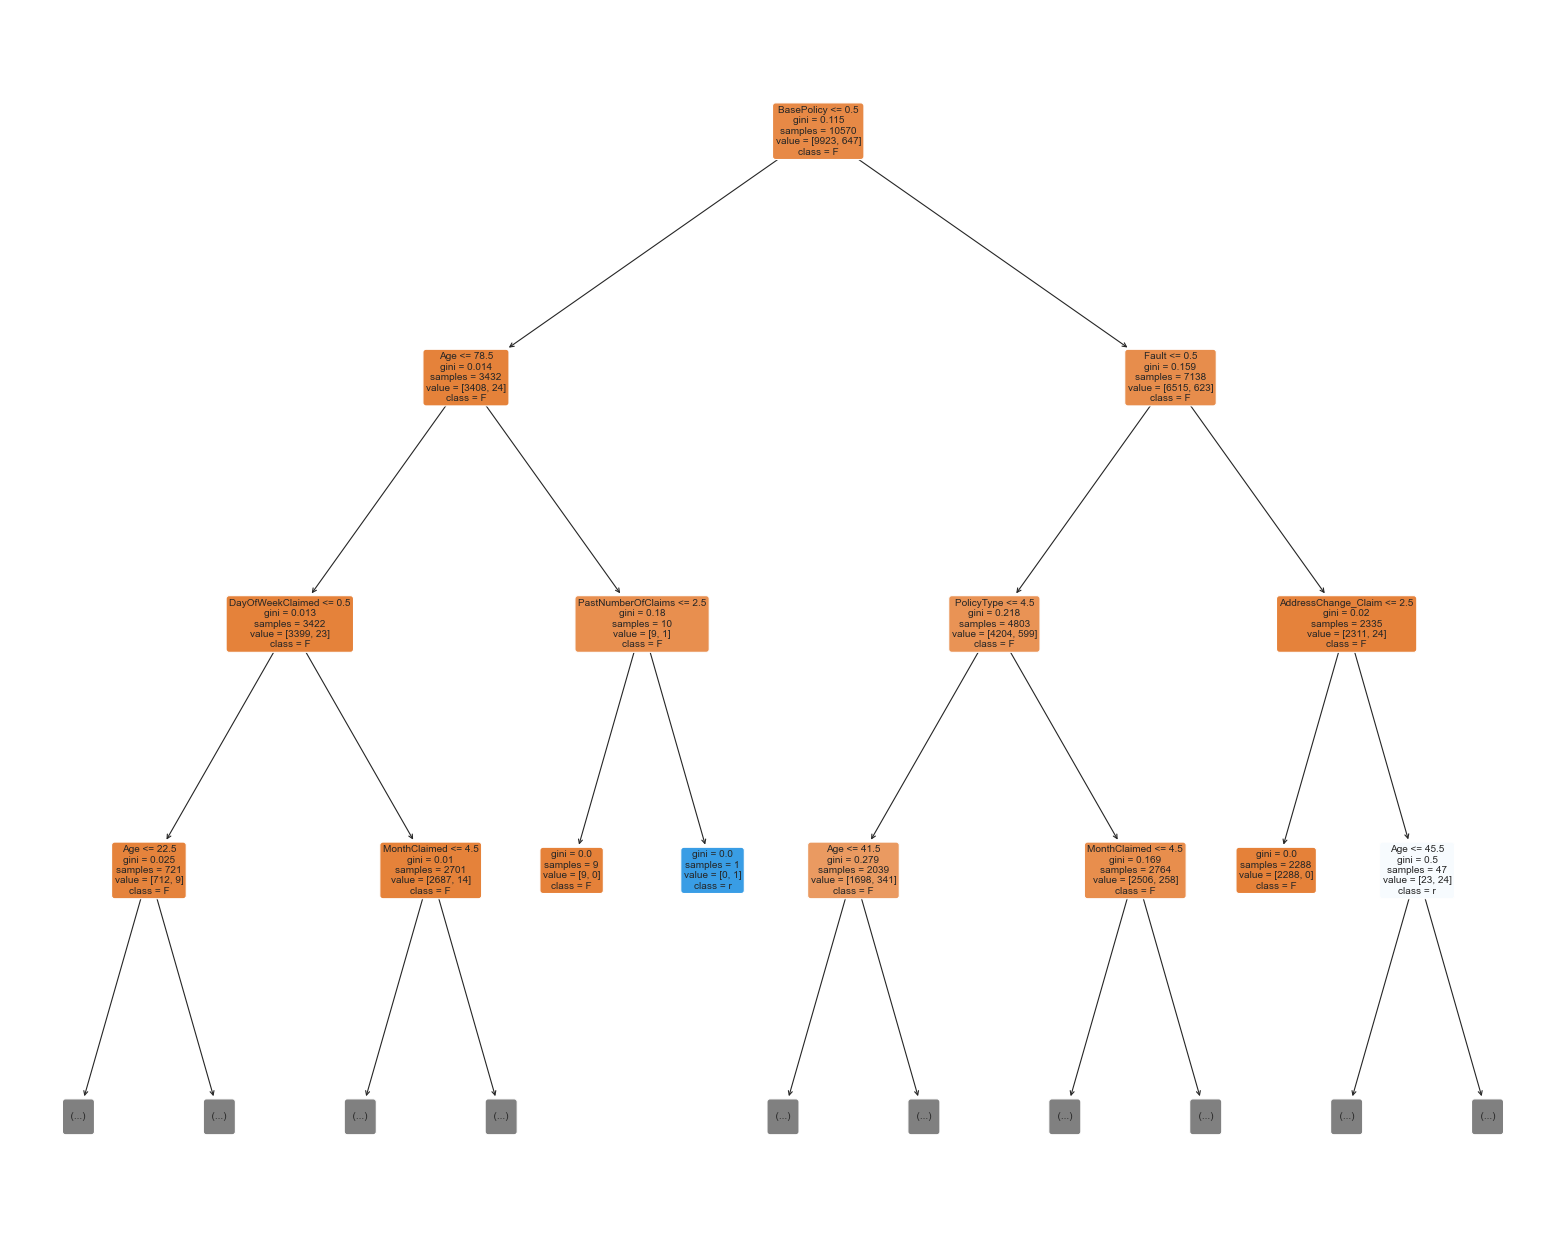

In [37]:
plt.figure(figsize=(25, 20), dpi=80)

decisionTree: DecisionTreeClassifier = DecisionTreeClassifier(max_depth=16)

make_prediction(decisionTree, divided_data)

_ = tree.plot_tree(decisionTree, feature_names=divided_data['x_train'].columns, class_names='Fraud_Found_P',
    filled=True, rounded=True, max_depth=3)

*Analiza wykonanej wizualizacji:*
> Niestety wykonanie drzewa decyzyjnego o głębokości 16 okazała się niewykonalna, więc w celu samej wizualizacji i zobaczenia jak wygląda drzewo decyzyjne dla zbioru, wykonaliśmy drzewo decyzyjne o max_depth = 3. Możemy zobaczyć, jak zbiór nam się dzielił w poszczególnych testach oraz jaka konkretna ścieżka na drzewie prowadziła do konkretnie wykonanej klasyfikacji zgłoszenia.

*Ogólna ocena klasyfikatora:*
> W odczuciu ogólnym klasyfikator działa bardzo dobrze. Zbiór testowy zostaje rozpoznany na poziomie 91%, natomiast zbiór testowy na poziomie 98%. Jest to dobry wynik klasyfikacji. Grupa podjęła decyzje, że najlepszą głębokością drzewa będzie głębokość = 16.

Przeprowadzimy teraz test dla klasyfikatora *Najbliższego Centroidu*.
> Klasyfikator najbliższego centroidu wykorzystuje metodę odległości euklidesowej do określenia odległości między centroidami a nowym przypadkiem.

In [41]:
nearestCentroid: NearestCentroid = NearestCentroid()

make_prediction(nearestCentroid, divided_data)

ConfusionMatrix - learning set, accuracy: 0.8990539262062441
[[9444  479]
 [ 588   59]]
              precision    recall  f1-score   support

    NO FRAUD       0.94      0.95      0.95      9923
       FRAUD       0.11      0.09      0.10       647

    accuracy                           0.90     10570
   macro avg       0.53      0.52      0.52     10570
weighted avg       0.89      0.90      0.89     10570

ConfusionMatrix - test set, accuracy: 0.9061810154525386
[[4080  205]
 [ 220   25]]
              precision    recall  f1-score   support

    NO FRAUD       0.95      0.95      0.95      4285
       FRAUD       0.11      0.10      0.11       245

    accuracy                           0.91      4530
   macro avg       0.53      0.53      0.53      4530
weighted avg       0.90      0.91      0.90      4530



Wnioski:
> Klasyfikator dobrze radzi sobie z wykrywaniem przypadków bez oszustwa. Niestety nie radzi sobie z wykrywaniem przypadków oszustwa, co wynika z niskiej precyzji, czułości i wyniku f1-score dla klasy FRAUD.

> Dokładność klasyfikatora jest wysoka (91%), jednak jeśli spojrzymy uśrednioną wartość f1-score jest ona niska (0.52), co oznacza, że klasyfikator nie radzi sobie dobrze z obiema klasami.
Ten klasyfikator wypadł znacznie gorzej od drzewa decyzyjnego. 

Przeprowadzimy teraz test dla *Gaussowskiego Naiwnego klasyfikatora Bayessa*.

Klasyfikator ten zakłada, że każda cecha jest niezależna od pozostałych i ma rozkład normalny. Prawdopodobieństwo przynależności do danej klasy jest określane na podstawie średniej i odchylenia standardowego każdej zmiennej dla każdej klasy. 

In [40]:
gauss: GaussianNB = GaussianNB()

make_prediction(gauss, divided_data)

ConfusionMatrix - learning set, accuracy: 0.8717123935666982
[[9084  839]
 [ 517  130]]
              precision    recall  f1-score   support

    NO FRAUD       0.95      0.92      0.93      9923
       FRAUD       0.13      0.20      0.16       647

    accuracy                           0.87     10570
   macro avg       0.54      0.56      0.55     10570
weighted avg       0.90      0.87      0.88     10570

ConfusionMatrix - test set, accuracy: 0.8774834437086093
[[3930  355]
 [ 200   45]]
              precision    recall  f1-score   support

    NO FRAUD       0.95      0.92      0.93      4285
       FRAUD       0.11      0.18      0.14       245

    accuracy                           0.88      4530
   macro avg       0.53      0.55      0.54      4530
weighted avg       0.91      0.88      0.89      4530



Wnioski:
> Gaussowski Naiwny klasyfikator Bayesa nie daje najlepszych wyników. Zbiór uczący zostaje rozpoznany na poziomie 88%, zbiór testowy na poziomie również 88%. Jest to gorszy wynik od poprzedników. Metryka f1 dla danych testowych jest na poziomie 0.95 dla prawidłowych zgłoszeń i 0.09 dla oszustw. Czułość na poziomie 19% dla oszustw jest całkiem niezła - prawie co piąte wykryte jako oszustwo zgłoszenie rzeczywiście nim jest. Jednak ten klasyfikator również wypadł gorzej od drzewa decyzyjnego, przede wszystkich przez słabą dokładność. 

> Klasyfikator dobrze radzi sobie z wykrywaniem przypadków bez oszustwa. Radzi sobie trochę lepiej z wykrywaniem przypadków oszustwa niż klasyfikator Najbliższego Centroidu, jednak wynik dalej jest dosyć słaby, co wynika z niskiej precyzji, czułości i wyniku f1-score dla klasy FRAUD.

> Dokładność klasyfikatora jest dosyć wysoka(88%), jednak jeśli spojrzymy na uśrednioną wartość f1-score jest ona niska (0.52), co oznacza, że klasyfikator nie radzi sobie dobrze z obiema klasami. Ten klasyfikator wypadł gorzej od drzewa decyzyjnego.

## Podsumowanie projektu

* W projekcie zajęliśmy się problemem weryfikacji wyłudzeń ubezpieczeń. Przeanalizowaliśmy w tym celu zbiór danych firmy **Oracle**.
* Rozpoczęliśmy pracę od wczytania danych do środowiska pracy Azure. Dzięki niemu poznaliśmy zbiór i ukierunkowaliśmy naszą pracę w projekcie.
* Następnym krokiem było przeprowadzenie dokładnej analizy eksploracyjnej danych, na drodze której zweryfikowaliśmy nasze hipotezy dotyczące posiadanych danych oraz zdecydowaliśmy, które atrybuty są nam potrzebne. Dzięki odpowiedniej analizie udało nam się zredukować w zbiorze liczbę atrybutów do najbardziej istotnych.
* Ostatnim, a zarazem najważniejszym etapem realizacji projektu było wykonanie klasyfikacji, a co za tym idzie wybór odpowiedniego klasyfikatora. Po przeanalizowaniu znanych nam klasyfikatorów uznaliśmy, że **Drzewo Decyzyjne** jest najbardziej odpowiednie do rozwiązywania tego problemu. Jego dokładność dla zbioru uczącego to prawie 98%, natomiast testowego prawie aż 92%. Należy jednak zaznaczyć, że nie można opierać się tutaj na samej mierze dokładności, ponieważ przypadków bez oszustw jest nieporównywalnie więcej od oszustw.